# Import Library

In [ ]:
# Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
import shutil, os, glob, re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, to_date, to_timestamp, when, expr, date_trunc, count, avg, coalesce
from pyspark.sql.functions import explode, split, trim
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import count as Fcount
from pyspark.sql import Window
from pyspark.sql.functions import col, trim, upper, initcap
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from itertools import product
from pyspark.sql.functions import udf

spark = SparkSession.builder \
    .appName("BNPL_feature_ranking") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/07 18:01:06 WARN Utils: Your hostname, xuzhengs-MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 192.168.112.40 instead (on interface en0)
25/10/07 18:01:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/07 18:01:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/07 18:01:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Read File

In [2]:
initial_transaction = spark.read.parquet("initial_transaction.parquet")

In [3]:
initial_transaction.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)



In [4]:
initial_transaction.show(10)

+------------+-----------+-----+--------+-------+--------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+--------------------+------------------+----------+-----------+
|merchant_abn|consumer_id|state|postcode|user_id|            order_id|      dollar_value|gender|order_datetime|year_month|     pop|median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob|              m_name|      c_fraud_prob|m_category|m_take_rate|
+------------+-----------+-----+--------+-------+--------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+--------------------+------------------+----------+-----------+
| 33604812025|        551|  NSW|    2021|   3471|f381a114-18d7-4c7...|219.94202939977228|  Male|    2022-05-25|   2022-05|131814.5|  

# Fruad Feature

In [5]:
# Base table preprocessing
tx = initial_transaction

# Ensure there is a "Day" key; Your order_datetime is already of the date type
tx = tx.withColumn("order_day", F.col("order_datetime").cast("date"))

### Feature 1: Multiple Consumption at the same merchant on the same day (consumer_id, merchant_abn, order_day)
w_cm_day = Window.partitionBy("consumer_id", "merchant_abn", "order_day")

tx = (tx
    .withColumn("f1_cm_day_tx_cnt", F.count("*").over(w_cm_day))            # The number of times at the same merchant on the same day
    .withColumn("f1_cm_day_amt_sum", F.sum("dollar_value").over(w_cm_day))  # The amount of the same merchant on the same day
    .withColumn("f1_same_day_multi_flag", (F.col("f1_cm_day_tx_cnt") >= 2).cast("int"))  # Whether it is >= 2 times
)

### Feature 2: First order vs. Subsequent amount anomaly (consumer_id, merchant_abn)
# For stable sorting, by day order_id (order_id is a string and can also be used as order)
w_cm_order = Window.partitionBy("consumer_id", "merchant_abn").orderBy("order_day", "order_id")

# Get the "First order amount" within the group (in chronological order)
w_cm_all = Window.partitionBy("consumer_id", "merchant_abn") \
                 .orderBy("order_day", "order_id") \
                 .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

tx = (tx
    .withColumn("f2_tx_seq_in_cm", F.row_number().over(w_cm_order))  # The serial number within this consumer-merchant
    .withColumn("f2_first_amt_in_cm", F.first("dollar_value", ignorenulls=True).over(w_cm_all))
    .withColumn(
        "f2_ratio_to_first",
        F.when(F.col("f2_first_amt_in_cm") > 0, F.col("dollar_value") / F.col("f2_first_amt_in_cm"))
         .otherwise(F.lit(None))
    )
    .withColumn("f2_delta_vs_first", F.col("dollar_value") - F.col("f2_first_amt_in_cm"))
)

# Define a "large" threshold
RATIO_LARGE = 4.0

tx = tx.withColumn(
    "f2_large_increase_flag",
    ((F.col("f2_tx_seq_in_cm") > 1) & (F.col("f2_ratio_to_first") >= F.lit(RATIO_LARGE))).cast("int")
)

# Preview
tx.select(
    "consumer_id","merchant_abn","order_day","dollar_value",
    "f1_cm_day_tx_cnt","f1_same_day_multi_flag",
    "f2_tx_seq_in_cm","f2_first_amt_in_cm","f2_ratio_to_first","f2_large_increase_flag"
).show(20, truncate=False)

+-----------+------------+----------+------------------+----------------+----------------------+---------------+------------------+-------------------+----------------------+
|consumer_id|merchant_abn|order_day |dollar_value      |f1_cm_day_tx_cnt|f1_same_day_multi_flag|f2_tx_seq_in_cm|f2_first_amt_in_cm|f2_ratio_to_first  |f2_large_increase_flag|
+-----------+------------+----------+------------------+----------------+----------------------+---------------+------------------+-------------------+----------------------+
|30         |15130143460 |2021-12-17|333.6990902806271 |1               |0                     |1              |333.6990902806271 |1.0                |0                     |
|30         |16058191622 |2022-10-21|1164.4159254800377|1               |0                     |1              |1164.4159254800377|1.0                |0                     |
|30         |16570599421 |2021-04-06|34.2207648860906  |1               |0                     |1              |34.2207648860

In [6]:
# Count the number of transactions for each merchant under consumer-month
cm_month = (tx
    .groupBy("consumer_id", "year_month", "merchant_abn")
    .agg(F.count("*").alias("cm_month_cnt"))
)

# The total number of transactions and the number of merchants involved in this consumer-month
cm_month_tot = (cm_month
    .groupBy("consumer_id", "year_month")
    .agg(
        F.sum("cm_month_cnt").alias("month_tx_cnt"),
        F.countDistinct("merchant_abn").alias("month_merchant_cnt")
    )
)

# Calculate the share of each merchant in this consumer-month
cm_share = (cm_month
    .join(cm_month_tot, ["consumer_id", "year_month"], "inner")
    .withColumn("share", F.col("cm_month_cnt") / F.col("month_tx_cnt"))
)

# Consumption concentration indicators: HHI, proportion of Top1/Top3
# HHI = Σ share^2
f3_hhi = (cm_share
    .groupBy("consumer_id", "year_month")
    .agg(F.sum(F.pow(F.col("share"), 2)).alias("f3_hhi"))
)

# The proportion of Top1 to top 3
w_rank = Window.partitionBy("consumer_id", "year_month").orderBy(F.col("share").desc())

cm_ranked = cm_share.withColumn("rk", F.row_number().over(w_rank))

f3_top1 = (cm_ranked
    .filter(F.col("rk") == 1)
    .select("consumer_id", "year_month", F.col("share").alias("f3_top1_share"))
)

f3_top3 = (cm_ranked
    .filter(F.col("rk") <= 3)
    .groupBy("consumer_id", "year_month")
    .agg(F.sum("share").alias("f3_top3_share"))
)

# Summarize Feature 3 and generate a "high concentration" tag
f3_summary = (cm_month_tot
    .selectExpr(
        "consumer_id",
        "year_month",
        "month_tx_cnt  as f3_month_tx_cnt",
        "month_merchant_cnt as f3_month_merchant_cnt"
    )
    .join(f3_hhi,  ["consumer_id", "year_month"], "left")
    .join(f3_top1, ["consumer_id", "year_month"], "left")
    .join(f3_top3, ["consumer_id", "year_month"], "left")
)

# High concentration flag: Top1 proportion >=0.8 or HHI>=0.5
f3_summary = f3_summary.withColumn(
    "f3_high_conc_flag",
    ((F.col("f3_top1_share") >= 0.8) | (F.col("f3_hhi") >= 0.5)).cast("int")
)

# Write back to the transaction-by-transaction table tx (connected by consumer_id, year_month)
tx = tx.join(f3_summary, ["consumer_id", "year_month"], "left")

# Preview
tx.select(
    "consumer_id","year_month","merchant_abn",
    "f3_month_tx_cnt","f3_month_merchant_cnt",
    "f3_top1_share","f3_top3_share","f3_hhi","f3_high_conc_flag"
).show(20, truncate=False)

+-----------+----------+------------+---------------+---------------------+--------------------+-------------------+-------------------+-----------------+
|consumer_id|year_month|merchant_abn|f3_month_tx_cnt|f3_month_merchant_cnt|f3_top1_share       |f3_top3_share      |f3_hhi             |f3_high_conc_flag|
+-----------+----------+------------+---------------+---------------------+--------------------+-------------------+-------------------+-----------------+
|551        |2021-06   |43186523025 |24             |22                   |0.125               |0.20833333333333331|0.05208333333333334|0                |
|551        |2021-06   |68216911708 |24             |22                   |0.125               |0.20833333333333331|0.05208333333333334|0                |
|551        |2021-06   |84937597269 |24             |22                   |0.125               |0.20833333333333331|0.05208333333333334|0                |
|551        |2021-06   |35424691626 |24             |22               

In [7]:
### Feature 4: Regional Anomalies (Rapid state Switching)

# Sort each consumer by time and take the state and date of the last transaction
w_c_time = Window.partitionBy("consumer_id").orderBy("order_datetime", "order_id")

tx = (tx
    .withColumn("f4_prev_state", F.lag("state").over(w_c_time))
    .withColumn("f4_prev_date",  F.lag("order_datetime").over(w_c_time))
)

# Transaction-by-transaction features: whether to switch, the number of days since the last transaction, whether to "switch quickly"
# Threshold: Switching is considered a fast switch if the number of days is less than or equal to 7
DAYS_FAST = 7

tx = (tx
    .withColumn("f4_state_changed",
                (F.col("state") != F.col("f4_prev_state")).cast("int"))
    .withColumn("f4_days_since_prev",
                F.when(F.col("f4_prev_date").isNull(), None)
                 .otherwise(F.datediff(F.col("order_datetime"), F.col("f4_prev_date"))))
    .withColumn("f4_fast_switch_flag",
                ( (F.col("f4_state_changed") == 1) &
                  (F.col("f4_days_since_prev").isNotNull()) &
                  (F.col("f4_days_since_prev") <= F.lit(DAYS_FAST)) ).cast("int"))
)

# Monthly aggregation (Consumer-month) : Number of switches, number of quick switches, and the number of different states involved in the current month
f4_month = (tx
    .groupBy("consumer_id", "year_month")
    .agg(
        F.sum("f4_state_changed").alias("f4_month_switch_cnt"),
        F.sum("f4_fast_switch_flag").alias("f4_month_fast_switch_cnt"),
        F.countDistinct("state").alias("f4_month_unique_states")
    )
)

# Write back to the transaction-by-transaction table
tx = tx.join(f4_month, ["consumer_id", "year_month"], "left")

# Preview
tx.select(
    "consumer_id","order_datetime","state","f4_prev_state","f4_days_since_prev",
    "f4_state_changed","f4_fast_switch_flag",
    "year_month","f4_month_switch_cnt","f4_month_fast_switch_cnt","f4_month_unique_states"
).show(20, truncate=False)

+-----------+--------------+-----+-------------+------------------+----------------+-------------------+----------+-------------------+------------------------+----------------------+
|consumer_id|order_datetime|state|f4_prev_state|f4_days_since_prev|f4_state_changed|f4_fast_switch_flag|year_month|f4_month_switch_cnt|f4_month_fast_switch_cnt|f4_month_unique_states|
+-----------+--------------+-----+-------------+------------------+----------------+-------------------+----------+-------------------+------------------------+----------------------+
|226        |2021-03-02    |SA   |NULL         |NULL              |NULL            |0                  |2021-03   |0                  |0                       |1                     |
|226        |2021-03-02    |SA   |SA           |0                 |0               |0                  |2021-03   |0                  |0                       |1                     |
|226        |2021-03-04    |SA   |SA           |2                 |0            

In [8]:
# Select the required columns
feature_cols = [
    "consumer_id", "merchant_abn", "order_id", "order_datetime", "dollar_value", "state",
    # feature 1
    "f1_cm_day_tx_cnt", "f1_same_day_multi_flag",
    # feature 2
    "f2_tx_seq_in_cm", "f2_first_amt_in_cm", "f2_ratio_to_first", "f2_large_increase_flag",
    # feature 3
    "f3_month_tx_cnt", "f3_month_merchant_cnt", "f3_top1_share", "f3_top3_share", "f3_hhi", "f3_high_conc_flag",
    # feature 4
    "f4_days_since_prev", "f4_state_changed", "f4_fast_switch_flag",
    "f4_month_switch_cnt", "f4_month_fast_switch_cnt", "f4_month_unique_states"
]

# Only keep these columns
final_fraud_features = tx.select(feature_cols)

In [9]:
# Define the main table and the feature table
base_df = initial_transaction
feat_df = final_fraud_features

# Here, consumer_id merchant_abn order_id is used as the unique key for Join
final_fraud = (
    base_df.join(
        feat_df,
        on=["consumer_id", "merchant_abn", "order_id"],
        how="left"   # keep all the transaction
    )
)

# Preview
final_fraud.printSchema()
final_fraud.show(10, truncate=False)


root
 |-- consumer_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 

25/10/07 18:02:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+------------+------------------------------------+-----+--------+-------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+----------------------------+------------------+-------------------+-----------+--------------+------------------+-----+----------------+----------------------+---------------+------------------+--------------------+----------------------+---------------+---------------------+--------------------+-------------------+--------------------+-----------------+------------------+----------------+-------------------+-------------------+------------------------+----------------------+
|consumer_id|merchant_abn|order_id                            |state|postcode|user_id|dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob|m_name                      |c_fraud

# Feature Engineering about Fruad Label

In [10]:
# Use the samples with m_fraud_prob to check the accuracy
labeled = (
    final_fraud
    .filter(F.col("m_fraud_prob").isNotNull())
    .cache()
)

print("labeled rows =", labeled.count())
labeled.printSchema()

labeled rows = 1939087
root
 |-- consumer_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- order_datetime: d

In [11]:
### Continuous feature: m_fraud_prob correlation

# Automatically recognize numerical columns
num_types = {"int", "bigint", "double", "float", "long", "decimal", "smallint"}
schema = labeled.schema

numeric_cols_all = [f.name for f in schema
                    if any(t in str(f.dataType).lower() for t in num_types)]

# Exclude columns that are not suitable as features
exclude_cols = {
    "m_fraud_prob", "consumer_id", "merchant_abn", "order_id",
    "user_id", "postcode", "year", "year_month", "order_datetime", "m_name", "state"
}
numeric_features = [c for c in numeric_cols_all if c not in exclude_cols]

# Calculate the correlation coefficient
corr_rows = []
for c in numeric_features:
    try:
        # The column must be non-empty and have variance; otherwise, corr will return None
        n_nonnull = labeled.filter(F.col(c).isNotNull()).count()
        if n_nonnull >= 5:  
            corr = labeled.stat.corr(c, "m_fraud_prob")
            corr_rows.append((c, float(corr) if corr is not None else None, n_nonnull))
    except Exception as e:
        corr_rows.append((c, None, 0))

corr_df = (
    spark.createDataFrame(corr_rows, ["feature", "pearson_corr", "n_nonnull"])
    .withColumn("abs_corr", F.abs(F.col("pearson_corr")))
    .orderBy(F.desc_nulls_last("abs_corr"))
)

print("=== Correlation between continuous features and m_fraud_prob (sorted by corr) ===")
corr_df.show(50, truncate=False)

{"ts": "2025-10-07 18:04:36.927", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[AMBIGUOUS_REFERENCE] Reference `dollar_value` is ambiguous, could be: [`dollar_value`, `dollar_value`]. SQLSTATE: 42704", "context": {"file": "line 22 in cell [11]", "line": "", "fragment": "col", "errorClass": "AMBIGUOUS_REFERENCE"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o422.filter.\n: org.apache.spark.sql.AnalysisException: [AMBIGUOUS_REFERENCE] Reference `dollar_value` is ambiguous, could be: [`dollar_value`, `dollar_value`]. SQLSTATE: 42704\n\tat org.apache.spark.sql.errors.QueryCompilationErrors$.ambiguousReferenceError(QueryCompilationErrors.scala:2163)\n\tat org.apache.spark.sql.catalyst.expressions.package$AttributeSeq.resolve(package.scala:356)\n\tat org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveChildren(LogicalPlan.scala:164)\n\tat org.apache.spark.sql.catalyst.analysis.ColumnResolutionHelper.$anonfun$resolveExpressi

=== Correlation between continuous features and m_fraud_prob (sorted by corr) ===
+------------------------+----------------------+---------+---------------------+
|feature                 |pearson_corr          |n_nonnull|abs_corr             |
+------------------------+----------------------+---------+---------------------+
|f2_first_amt_in_cm      |0.2575077770905016    |1939087  |0.2575077770905016   |
|f1_cm_day_tx_cnt        |0.2573157746110368    |1939087  |0.2573157746110368   |
|f3_top1_share           |0.21943880962284856   |1939087  |0.21943880962284856  |
|f3_top3_share           |0.18155875191852053   |1939087  |0.18155875191852053  |
|m_take_rate             |-0.14772287355105446  |1939087  |0.14772287355105446  |
|f3_hhi                  |0.14415846472513758   |1939087  |0.14415846472513758  |
|f3_month_tx_cnt         |0.10071608450368424   |1939087  |0.10071608450368424  |
|f2_large_increase_flag  |-0.07143775223041368  |1939087  |0.07143775223041368  |
|f1_same_day_mul

In [12]:
### "Mean comparison of rule /Flag features.

# Automatically find the flag column: a regular column ending with _flag or obviously 0/1
flag_cols = [c for c in labeled.columns if c.endswith("_flag")]

rows = []
for col in flag_cols:
    g = (
        labeled
        .groupBy(F.col(col).cast("int").alias("flag"))
        .agg(
            F.count(F.lit(1)).alias("cnt"),
            F.mean("m_fraud_prob").alias("avg_m_fraud_prob")
        )
        .orderBy("flag")
        .collect()
    )
    # Converting it to a dict makes it easier to calculate the lift
    stats = {int(r["flag"]): (r["cnt"], float(r["avg_m_fraud_prob"])) for r in g if r["flag"] is not None}
    cnt0, mean0 = stats.get(0, (0, None))
    cnt1, mean1 = stats.get(1, (0, None))
    lift = None
    if mean0 is not None and mean1 is not None and mean0 != 0:
        lift = mean1 / mean0
    rows.append((col, cnt0, mean0, cnt1, mean1, lift))

flag_lift_df = (
    spark.createDataFrame(rows, ["flag_feature", "cnt_flag0", "avg_prob_flag0", "cnt_flag1", "avg_prob_flag1", "lift_1_over_0"])
    .orderBy(F.desc_nulls_last("lift_1_over_0"))
)

print("=== Rule /Flag feature: Mean comparison of m_fraud_prob ===")
flag_lift_df.show(50, truncate=False)

=== Rule /Flag feature: Mean comparison of m_fraud_prob ===
+----------------------+---------+------------------+---------+------------------+------------------+
|flag_feature          |cnt_flag0|avg_prob_flag0    |cnt_flag1|avg_prob_flag1    |lift_1_over_0     |
+----------------------+---------+------------------+---------+------------------+------------------+
|f3_high_conc_flag     |1936909  |29.911156339228988|2178     |29.662963479580156|0.9917023315035359|
|f1_same_day_multi_flag|416519   |30.33854598344061 |1522568  |29.793883106594702|0.9820471660987578|
|f2_large_increase_flag|1815706  |29.98067051947731 |123381   |28.883786823577005|0.9634136369569285|
|f4_fast_switch_flag   |1939087  |29.910877566771486|0        |NULL              |NULL              |
+----------------------+---------+------------------+---------+------------------+------------------+



In [13]:
# Keep the key features
bin_features = [
    "f1_cm_day_tx_cnt",
    "f2_ratio_to_first",
    "f3_top1_share", "f3_hhi",
    "f4_month_switch_cnt", "f4_month_unique_states"
]

def bin_and_profile(df, feature, num_bins=4):
    # Use approximate quantiles for segmentation
    qs = df.approxQuantile(feature, [i/num_bins for i in range(num_bins+1)], 0.01)
    # Deduplication & sorting
    cuts = sorted(set(qs))
    # Avoid all the same situations
    if len(cuts) <= 2:
        return spark.createDataFrame([], schema="feature string, bin string, cnt long, avg_m_fraud_prob double")
    # Generate the bin boundary string
    bounds = list(zip(cuts[:-1], cuts[1:]))
    expr = F.when(F.col(feature).isNull(), F.lit("NULL"))
    for lo, hi in bounds:
        expr = expr.when((F.col(feature) >= lo) & (F.col(feature) <= hi), F.lit(f"[{lo:.4g}, {hi:.4g}]"))
    binned = df.select(
        F.lit(feature).alias("feature"),
        expr.otherwise(F.lit("OTHER")).alias("bin"),
        "m_fraud_prob"
    )
    return (
        binned.groupBy("feature", "bin")
        .agg(F.count("*").alias("cnt"), F.mean("m_fraud_prob").alias("avg_m_fraud_prob"))
        .orderBy("feature", "bin")
    )

bin_profiles = None
for ftr in bin_features:
    if ftr in labeled.columns:
        prof = bin_and_profile(labeled.filter(F.col(ftr).isNotNull()), ftr, num_bins=4)
        bin_profiles = prof if bin_profiles is None else bin_profiles.unionByName(prof, allowMissingColumns=True)

# Check which interval's fraud_prob is significantly higher
if bin_profiles is not None:
    print("=== The boxed mean of the key continuous features ===")
    bin_profiles.show(200, truncate=False)

=== The boxed mean of the key continuous features ===


+-----------------+------------------+-------+------------------+
|feature          |bin               |cnt    |avg_m_fraud_prob  |
+-----------------+------------------+-------+------------------+
|f1_cm_day_tx_cnt |[1, 2]            |642535 |29.8987868113453  |
|f1_cm_day_tx_cnt |[2, 3]            |926640 |28.902389836158786|
|f1_cm_day_tx_cnt |[3, 12]           |369912 |32.458169366532445|
|f2_ratio_to_first|[1, 3.495e+05]    |422015 |29.0172482257586  |
|f2_ratio_to_first|[3.924e-05, 1]    |1517072|30.15946496825753 |
|f3_top1_share    |[0.01818, 0.07407]|495262 |29.67510942949334 |
|f3_top1_share    |[0.07407, 0.09375]|481447 |29.24320891075551 |
|f3_top1_share    |[0.09375, 0.1364] |480395 |29.297081951724135|
|f3_top1_share    |[0.1364, 1]       |481983 |31.431840785658654|
|f3_hhi           |[0.01607, 0.03498]|479400 |29.472955461365377|
|f3_hhi           |[0.03498, 0.04252]|484910 |29.457293019945883|
|f3_hhi           |[0.04252, 0.055]  |476528 |29.569715512035838|
|f3_hhi   

25/10/07 18:05:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


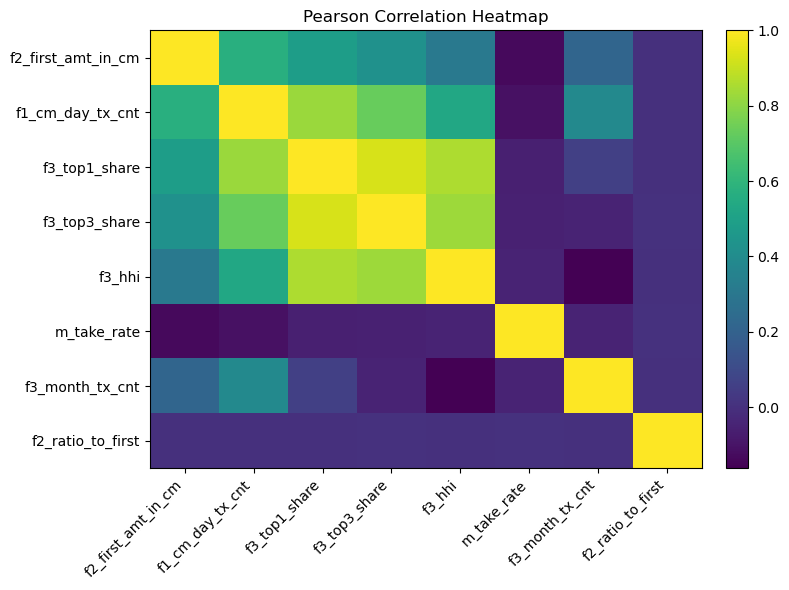

In [14]:
# ===== Correlation Heatmap (Matplotlib, no seaborn) =====


# Want to view the continuous characteristics of correlation
features_of_interest = [
    "f2_first_amt_in_cm",
    "f1_cm_day_tx_cnt",
    "f3_top1_share",
    "f3_top3_share",
    "f3_hhi",
    "m_take_rate",
    "f3_month_tx_cnt",
    "f2_ratio_to_first",
]

# Keep only these columns and unify them as double, removing all blank rows
num_df = labeled.select(*[F.col(c).cast("double").alias(c) for c in features_of_interest]).na.drop(how="any")

# Assemble it into a vector column to calculate the correlation matrix at one time
assembler = VectorAssembler(inputCols=features_of_interest, outputCol="features_vec")
vec_df = assembler.transform(num_df).select("features_vec")

# Calculate the Pearson correlation matrix
corr_mat = Correlation.corr(vec_df, "features_vec", "pearson").head()[0].toArray()

# Heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_mat, interpolation="nearest", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)

# Axis Label
plt.xticks(ticks=np.arange(len(features_of_interest)), labels=features_of_interest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(features_of_interest)), labels=features_of_interest)
plt.title("Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()

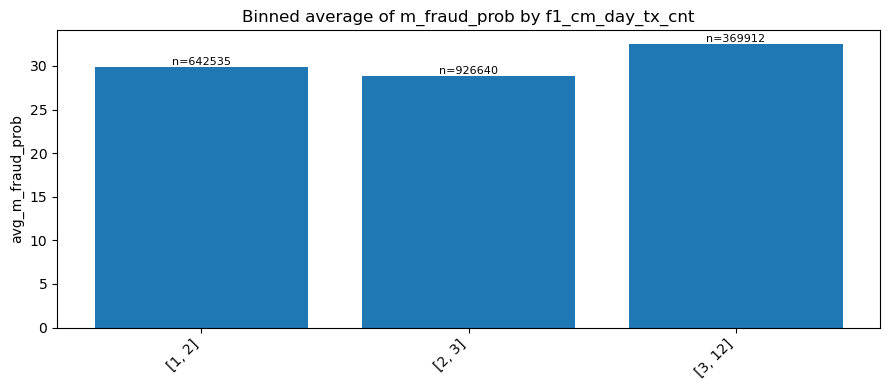

In [15]:
### Binned Mean Bar Chart (per feature) 

# Select the feature you want to visualize (this feature needs to be already in bin_profiles)
feature_to_plot = "f1_cm_day_tx_cnt"   

# Take out the box distribution result of this feature
bp = (
    bin_profiles
    .filter(F.col("feature") == feature_to_plot)
    .select("bin", "cnt", "avg_m_fraud_prob")
    .toPandas()
)

# Column sort: Parse the interval string "[a, b]" of bin into numerical values for sorting
def bin_key(s):
    # Extract the first number as the sorting key; When the parsing fails, place it at the end
    try:
        nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
        return float(nums[0]) if nums else float("inf")
    except Exception:
        return float("inf")

bp["sort_key"] = bp["bin"].apply(bin_key)
bp = bp.sort_values(by="sort_key")

# Draw a graph (bar: avg_m_fraud_prob for different bins; the number of samples cnt can also be marked above the column)
plt.figure(figsize=(9, 4))
x = np.arange(len(bp))
plt.bar(x, bp["avg_m_fraud_prob"].values)
plt.xticks(x, bp["bin"].values, rotation=45, ha="right")
plt.ylabel("avg_m_fraud_prob")
plt.title(f"Binned average of m_fraud_prob by {feature_to_plot}")

# Mark the sample size above the column
for xi, yi, ci in zip(x, bp["avg_m_fraud_prob"].values, bp["cnt"].values):
    plt.text(xi, yi, f"n={int(ci)}", ha="center", va="bottom", fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

### is_fraud_rule Label

In [16]:
### Baseline Setup & Threshold Grid (for fraud rule evaluation)

# Evaluate baseline using only samples with m_fraud_prob label
baseline = labeled.agg(F.mean("m_fraud_prob")).first()[0]
total_labeled = labeled.count()
print(f"Baseline mean m_fraud_prob = {baseline:.4f}  | labeled rows = {total_labeled:,}")

# # Define threshold grid (based on boxplot inspection, can be adjusted/expanded)
# tx_cnt: number of transactions per customer in a month
# hhi: Herfindahl-Hirschman Index of merchant concentration
# top1_share: proportion of top-1 product in merchant’s sales
grid = {
    "tx_cnt":      [3, 4, 5],          # f1_cm_day_tx_cnt >= ?
    "hhi":         [0.050, 0.055, 0.060],   # f3_hhi >= ?
    "top1_share":  [0.12, 0.13, 0.14],      # f3_top1_share >= ?
}


# Minimum support requirement (percentage of samples flagged as 1)
# This prevents overly narrow or extreme rule coverage
min_support_rate = 0.01  # 1%

Baseline mean m_fraud_prob = 29.9109  | labeled rows = 1,939,087


In [17]:
### Block B: Rule Evaluation & Threshold Search
# Goal: Evaluate different threshold combinations (grid search)

def build_rule_expr(th):
    # th 是一个 dict: {"tx_cnt":x, "hhi":y, "top1_share":z}
    c1 = (F.col("f1_cm_day_tx_cnt") >= F.lit(th["tx_cnt"])) & (F.col("f3_hhi") >= F.lit(th["hhi"]))
    c2 = (F.col("f1_cm_day_tx_cnt") >= F.lit(2)) & (F.col("f3_top1_share") >= F.lit(th["top1_share"]))
    return (c1 | c2)

def evaluate_threshold(th):
    cond = build_rule_expr(th)
    tmp = (
        labeled
        .select(
            F.when(cond, 1).otherwise(0).alias("rule"),     # flag samples that meet rule
            "m_fraud_prob"
        )
        .groupBy("rule")
        .agg(
            F.count("*").alias("cnt"),                      # number of samples in each group
            F.mean("m_fraud_prob").alias("avg_prob")        # average fraud probability per group
        )
    )

    # Collect summary statistics
    stats = {int(r["rule"]): (r["cnt"], float(r["avg_prob"])) for r in tmp.collect()}
    cnt1, avg1 = stats.get(1, (0, None))
    cnt0, avg0 = stats.get(0, (0, None))

    # Compute metrics
    support = cnt1 / total_labeled if total_labeled else 0.0                # proportion of flagged samples
    lift = (avg1 / baseline) if (avg1 is not None and baseline) else None   # Lift vs. baseline mean
    delta = (avg1 - baseline) if (avg1 is not None) else None               # Difference vs. baseline mean

    return {
        "tx_cnt": th["tx_cnt"],
        "hhi": th["hhi"],
        "top1_share": th["top1_share"],
        "support": support,
        "cnt1": cnt1,
        "avg1": avg1,
        "baseline": baseline,
        "lift": lift,
        "delta": delta
    }

# Grid Search: iterate over all threshold combinations
results = []
for tx_cnt, hhi, top1 in product(grid["tx_cnt"], grid["hhi"], grid["top1_share"]):
    th = {"tx_cnt": tx_cnt, "hhi": hhi, "top1_share": top1}
    res = evaluate_threshold(th)
    if res["support"] >= min_support_rate and res["avg1"] is not None:
        results.append(res)

# Convert results to DataFrame
# Sort by Lift (primary) and delta (secondary) to identify strongest patterns
res_df = spark.createDataFrame(results)
res_df.orderBy(F.desc("lift"), F.desc("delta"), F.desc("support")).show(20, truncate=False)

+------------------+------------------+------+------------------+-----+------------------+-------------------+----------+------+
|avg1              |baseline          |cnt1  |delta             |hhi  |lift              |support            |top1_share|tx_cnt|
+------------------+------------------+------+------------------+-----+------------------+-------------------+----------+------+
|31.482297472759782|29.910877566771486|462743|1.5714199059882965|0.05 |1.052536736927238 |0.23863962782484746|0.14      |5     |
|31.482155229347157|29.910877566771486|462767|1.571277662575671 |0.05 |1.0525319813525376|0.23865200478369458|0.14      |4     |
|31.480609987378546|29.910877566771486|461628|1.5697324206070604|0.055|1.052480319813515 |0.23806461494507467|0.14      |5     |
|31.480559972166326|29.910877566771486|461636|1.5696824053948397|0.055|1.0524786476722645|0.23806874059802371|0.14      |4     |
|31.480483068390985|29.910877566771486|461553|1.569605501619499 |0.06 |1.052476076575005 |0.23802

In [18]:
### Block C: Select Best Threshold Combination & Apply to Full Dataset
# Objective: Identify the optimal threshold rule (highest Lift) and label all data points accordingly

# Step 1. Select the best-performing threshold combination 
best_row = (
    res_df
    .orderBy(F.desc("lift"), F.desc("delta"), F.desc("support"))
    .limit(1)
    .collect()[0]
)

best_th = {
    "tx_cnt": best_row["tx_cnt"],
    "hhi": best_row["hhi"],
    "top1_share": best_row["top1_share"]
}
print("Best thresholds:", best_th)

# Apply to all data
best_rule = build_rule_expr(best_th)
final_with_label = final_fraud.withColumn("is_fraud_rule", F.when(best_rule, 1).otherwise(0))

# Summarize the coverage rate
total_all = final_with_label.count()
labeled_all = final_with_label.groupBy("is_fraud_rule").count().orderBy("is_fraud_rule")
labeled_all.show()

# Verify Lift again on the labeled subset (as sanity check)
check = (
    final_with_label
    .filter(F.col("m_fraud_prob").isNotNull())
    .groupBy("is_fraud_rule")
    .agg(F.count("*").alias("cnt"), F.mean("m_fraud_prob").alias("avg_prob"))
    .orderBy("is_fraud_rule")
)
check.show()

Best thresholds: {'tx_cnt': 5, 'hhi': 0.05, 'top1_share': 0.14}


+-------------+--------+
|is_fraud_rule|   count|
+-------------+--------+
|            0|15085662|
|            1|  465384|
+-------------+--------+



+-------------+-------+------------------+
|is_fraud_rule|    cnt|          avg_prob|
+-------------+-------+------------------+
|            0|1476344| 29.41833412056579|
|            1| 462743|31.482297472760077|
+-------------+-------+------------------+



In [19]:
# The threshold of the best rule
best_rule = {
    "tx_cnt": 5,
    "hhi": 0.05,
    "top1_share": 0.14
}

# Stick the label
final_labeled = (
    final_fraud
    .withColumn(
        "is_fraud",
        F.when(
            (F.col("f1_cm_day_tx_cnt") >= best_rule["tx_cnt"]) &
            (F.col("f3_hhi") >= best_rule["hhi"]) &
            (F.col("f3_top1_share") >= best_rule["top1_share"]),
            F.lit(1)
        ).otherwise(F.lit(0))
    )
)

# Preview the label distribution
final_labeled.groupBy("is_fraud").count().show()

+--------+--------+
|is_fraud|   count|
+--------+--------+
|       1|  317816|
|       0|15233230|
+--------+--------+



In [20]:
final_labeled.show(10)

+-----------+------------+--------------------+-----+--------+-------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+--------------------+------------------+-------------------+-----------+--------------+------------------+-----+----------------+----------------------+---------------+------------------+--------------------+----------------------+---------------+---------------------+--------------------+-------------------+--------------------+-----------------+------------------+----------------+-------------------+-------------------+------------------------+----------------------+--------+
|consumer_id|merchant_abn|            order_id|state|postcode|user_id|      dollar_value|gender|order_datetime|year_month|     pop|median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob|              m_name|      c_fraud_prob|         m_category|m_take_

In [21]:
final_labeled.printSchema()

root
 |-- consumer_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 

# Revenue Feature

In [22]:
join_keys = ["consumer_id", "merchant_abn", "order_id"]
feat_cols_to_keep = [c for c in feat_df.columns if c in join_keys or c not in base_df.columns]
feat_df_clean = feat_df.select(feat_cols_to_keep)

final_fraud = base_df.join(feat_df_clean, on=join_keys, how="left")

final_labeled = (
    final_fraud
    .withColumn(
        "is_fraud",
        F.when(
            (F.col("f1_cm_day_tx_cnt") >= 5) &
            (F.col("f3_hhi") >= 0.05) &
            (F.col("f3_top1_share") >= 0.14),
            F.lit(1)
        ).otherwise(F.lit(0))
    )
)

In [23]:
spark = SparkSession.builder \
    .appName("Merchant_Ranking") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

df_non_fraud = final_labeled.filter(F.col("is_fraud") == 0)

print(f"Total non-fraud data: {df_non_fraud.count():,} records")
print(f"Number of merchants: {df_non_fraud.select('merchant_abn').distinct().count():,}")

25/10/07 18:08:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Total non-fraud data: 15,233,230 records


Number of merchants: 4,422


In [24]:
# Feature 1 - Three-Month Consecutive Revenue Growth Rate
merchant_month = df_non_fraud.groupBy("merchant_abn", "year_month", "m_category") \
    .agg(
        F.sum("dollar_value").alias("monthly_revenue"),
        F.count("*").alias("monthly_tx_count"),
        F.countDistinct("consumer_id").alias("monthly_customer_count")
    )

w_month = Window.partitionBy("merchant_abn").orderBy("year_month")
merchant_month = merchant_month.withColumn("prev_revenue", F.lag("monthly_revenue", 1).over(w_month)) \
    .withColumn("prev2_revenue", F.lag("monthly_revenue", 2).over(w_month))

merchant_growth = merchant_month.filter(
    (F.col("prev_revenue").isNotNull()) & 
    (F.col("prev2_revenue").isNotNull()) &
    (F.col("prev2_revenue") > 0)
).withColumn(
    "revenue_growth_3m",
    (F.col("monthly_revenue") - F.col("prev2_revenue")) / F.col("prev2_revenue") * 100
)

merchant_growth = merchant_growth.withColumn(
    "revenue_growth_3m_clean",
    F.when(F.col("revenue_growth_3m") < -100, -100)
     .when(F.col("revenue_growth_3m") > 500, 500)
     .otherwise(F.col("revenue_growth_3m"))
)

merchant_avg_growth = merchant_growth.groupBy("merchant_abn").agg(
    F.avg("revenue_growth_3m_clean").alias("avg_revenue_growth_3m")
)


In [25]:
# Feature 2: Average Transaction Amount
merchant_avg_tx = df_non_fraud.groupBy("merchant_abn").agg(
    F.avg("dollar_value").alias("avg_transaction_amount")
)

# Feature 3: Customer Repurchase Rate
customer_tx_count = df_non_fraud.groupBy("merchant_abn", "consumer_id").agg(
    F.count("*").alias("customer_tx_count")
)
merchant_repurchase = customer_tx_count.groupBy("merchant_abn").agg(
    F.count("*").alias("total_customers"),
    F.sum(F.when(F.col("customer_tx_count") > 1, 1).otherwise(0)).alias("repeat_customers")
).withColumn("repurchase_rate", F.col("repeat_customers") / F.col("total_customers") * 100)

# Feature 4: Average Take Rate
merchant_take_rate = df_non_fraud.groupBy("merchant_abn").agg(
    F.avg("m_take_rate").alias("avg_take_rate")
)

# Feature 5: Total Revenue
merchant_total_revenue = df_non_fraud.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue")
)

# Feature 6: Total Transactions
merchant_tx_count = df_non_fraud.groupBy("merchant_abn").agg(
    F.count("*").alias("total_transactions")
)

# Feature 7: Total Number of Customers
merchant_customer_count = df_non_fraud.groupBy("merchant_abn").agg(
    F.countDistinct("consumer_id").alias("unique_customers")
)

# Feature 8: Average Monthly Revenue
merchant_monthly_avg = merchant_month.groupBy("merchant_abn").agg(
    F.avg("monthly_revenue").alias("avg_monthly_revenue")
)

# Feature 9: Revenue Standard Deviation (Stability Indicator)
merchant_revenue_std = merchant_month.groupBy("merchant_abn").agg(
    F.stddev("monthly_revenue").alias("revenue_stddev")
)

# Feature 10: Average Spending per Customer
merchant_avg_per_customer = df_non_fraud.groupBy("merchant_abn", "consumer_id").agg(
    F.sum("dollar_value").alias("customer_total")
).groupBy("merchant_abn").agg(
    F.avg("customer_total").alias("avg_per_customer")
)

# Feature 11: Number of Active Months
merchant_active_months = df_non_fraud.groupBy("merchant_abn").agg(
    F.countDistinct("year_month").alias("active_months")
)

# Feature 12: Business Days
merchant_time_span = df_non_fraud.groupBy("merchant_abn").agg(
    F.datediff(F.max("order_datetime"), F.min("order_datetime")).alias("business_days")
)

# Feature 13: Monthly Customer Growth Rate
merchant_month_customer = merchant_month.withColumn("prev_customer", F.lag("monthly_customer_count", 1).over(w_month))
merchant_customer_growth = merchant_month_customer.filter(
    (F.col("prev_customer").isNotNull()) & (F.col("prev_customer") > 0)
).withColumn(
    "customer_growth_rate", 
    (F.col("monthly_customer_count") - F.col("prev_customer")) / F.col("prev_customer") * 100
)

# Handle Outliers
merchant_customer_growth = merchant_customer_growth.withColumn(
    "customer_growth_rate_clean",
    F.when(F.col("customer_growth_rate") < -100, -100)
     .when(F.col("customer_growth_rate") > 500, 500)
     .otherwise(F.col("customer_growth_rate"))
)

merchant_avg_customer_growth = merchant_customer_growth.groupBy("merchant_abn").agg(
    F.avg("customer_growth_rate_clean").alias("avg_customer_growth_rate")
)


In [26]:
# Merge all features
merchant_features = df_non_fraud.select("merchant_abn", "m_category", "m_name").distinct()

merchant_features = merchant_features \
    .join(merchant_avg_growth, "merchant_abn", "left") \
    .join(merchant_avg_tx, "merchant_abn", "left") \
    .join(merchant_repurchase.select("merchant_abn", "repurchase_rate"), "merchant_abn", "left") \
    .join(merchant_take_rate, "merchant_abn", "left") \
    .join(merchant_total_revenue, "merchant_abn", "left") \
    .join(merchant_tx_count, "merchant_abn", "left") \
    .join(merchant_customer_count, "merchant_abn", "left") \
    .join(merchant_monthly_avg, "merchant_abn", "left") \
    .join(merchant_revenue_std, "merchant_abn", "left") \
    .join(merchant_avg_per_customer, "merchant_abn", "left") \
    .join(merchant_active_months, "merchant_abn", "left") \
    .join(merchant_time_span, "merchant_abn", "left") \
    .join(merchant_avg_customer_growth, "merchant_abn", "left")

merchant_features = merchant_features.fillna(0, subset=[
    "avg_revenue_growth_3m", "repurchase_rate", "revenue_stddev", "avg_customer_growth_rate"
])

merchant_features.select([
    "merchant_abn", "avg_revenue_growth_3m", "avg_transaction_amount", 
    "repurchase_rate", "total_revenue"
]).show(10, truncate=False)

print("\nFeature statistics summary:")
merchant_features.select([
    "avg_revenue_growth_3m", "avg_transaction_amount", "repurchase_rate", 
    "avg_take_rate", "total_revenue", "total_transactions"
]).describe().show()


+------------+---------------------+----------------------+------------------+------------------+
|merchant_abn|avg_revenue_growth_3m|avg_transaction_amount|repurchase_rate   |total_revenue     |
+------------+---------------------+----------------------+------------------+------------------+
|95431176007 |32.164748619658276   |300.5394048325378     |7.0754716981132075|1026943.1463127816|
|18547244547 |8.390201677468339    |57.48837184017147     |0.5586592178770949|20695.813862461728|
|16248082282 |33.96013015930104    |475.1965008962656     |2.954209748892171 |662899.1187502905 |
|90994364089 |33.26888947647285    |310.8045914798388     |6.202573408116133 |1004831.2442543189|
|60240099150 |6.844614749734019    |328.6996552925105     |0.9628610729023385|241265.5469847027 |
|59853422669 |38.91316627133488    |327.40760555654094    |0.0               |82506.71660024831 |
|12434006854 |35.31104513448828    |504.0444690787274     |2.247191011235955 |733888.746978627  |
|61447419161 |32.305

+-------+---------------------+----------------------+------------------+-------------------+--------------------+------------------+
|summary|avg_revenue_growth_3m|avg_transaction_amount|   repurchase_rate|      avg_take_rate|       total_revenue|total_transactions|
+-------+---------------------+----------------------+------------------+-------------------+--------------------+------------------+
|  count|                 4422|                  4422|              4422|               4422|                4422|              4422|
|   mean|   40.567685955186136|    1430.5802500080863| 5.138920476025679|  4.444360018091349|   682053.6435768023|3444.8733604703752|
| stddev|     33.3181415591006|    3485.2468679878552|12.719016934890966| 1.7074173601706437|  3703665.9310280513|16846.993838313283|
|    min|   -96.80886935204775|     7.588293706879919|               0.0|0.10000000000000002|  10045.238144985376|                 1|
|    max|                500.0|     56552.39444305644|        

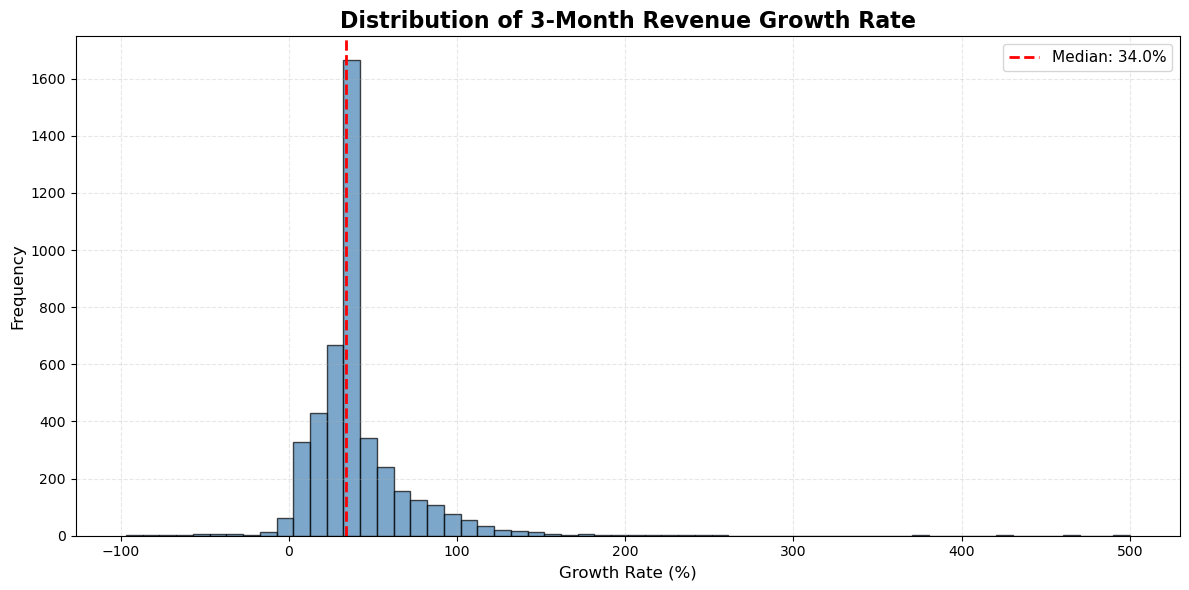

Figure 1: Distribution of Revenue Growth Rate Statistics
Sample size: 4422
Mean: 40.57%
Median: 34.05%
Standard Deviation: 33.32%
Minimum: -96.81%
Maximum: 500.00%


In [27]:
# Revenue Growth Rate Distribution
growth_data = merchant_features.select("avg_revenue_growth_3m").filter(
    F.col("avg_revenue_growth_3m").isNotNull()
).toPandas()

plt.figure(figsize=(12, 6))
plt.hist(growth_data['avg_revenue_growth_3m'], bins=60, edgecolor='black', 
         alpha=0.7, color='steelblue')
plt.axvline(growth_data['avg_revenue_growth_3m'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {growth_data["avg_revenue_growth_3m"].median():.1f}%')
plt.title('Distribution of 3-Month Revenue Growth Rate', fontsize=16, fontweight='bold')
plt.xlabel('Growth Rate (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 1: Distribution of Revenue Growth Rate Statistics")
print(f"Sample size: {len(growth_data)}")
print(f"Mean: {growth_data['avg_revenue_growth_3m'].mean():.2f}%")
print(f"Median: {growth_data['avg_revenue_growth_3m'].median():.2f}%")
print(f"Standard Deviation: {growth_data['avg_revenue_growth_3m'].std():.2f}%")
print(f"Minimum: {growth_data['avg_revenue_growth_3m'].min():.2f}%")
print(f"Maximum: {growth_data['avg_revenue_growth_3m'].max():.2f}%")


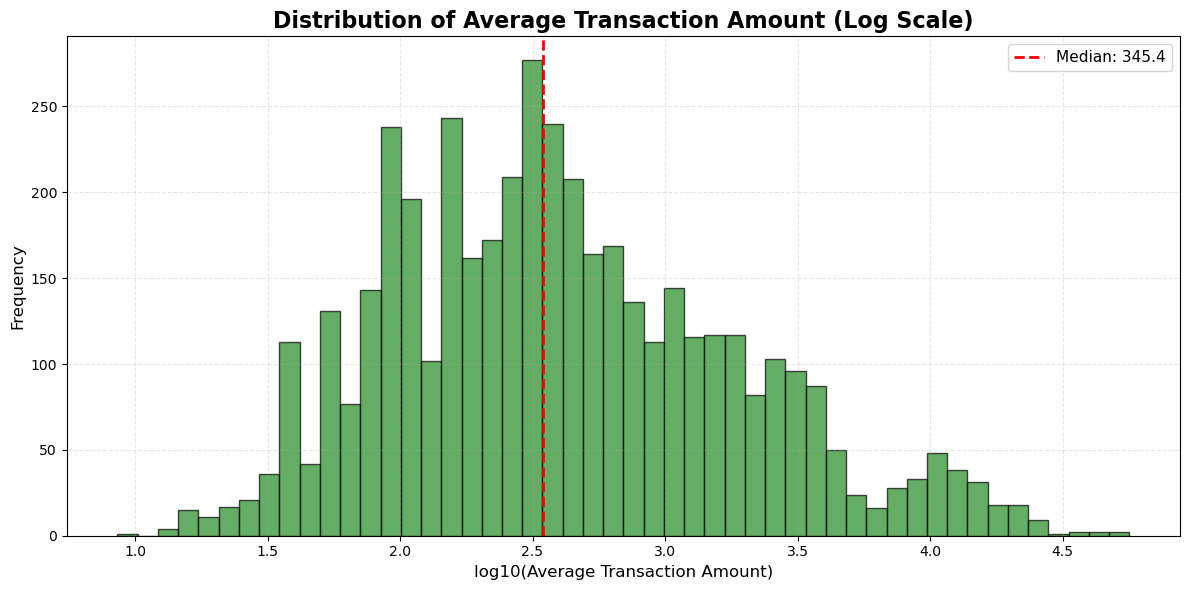

Figure 2: Distribution Statistics of Average Transaction Amount
Sample size: 4422
Mean: $1430.58
Median: $344.35
25th percentile: $129.59
75th percentile: $1075.14


In [28]:
# Average Transaction Amount Distribution (Log Scale)
tx_amount_data = merchant_features.select("avg_transaction_amount").toPandas()

plt.figure(figsize=(12, 6))
log_amounts = np.log10(tx_amount_data['avg_transaction_amount'] + 1)
plt.hist(log_amounts, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
plt.axvline(log_amounts.median(), color='red', linestyle='--', linewidth=2, 
            label=f'Median: {10**log_amounts.median():.1f}')
plt.title('Distribution of Average Transaction Amount (Log Scale)', fontsize=16, fontweight='bold')
plt.xlabel('log10(Average Transaction Amount)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 2: Distribution Statistics of Average Transaction Amount")
print(f"Sample size: {len(tx_amount_data)}")
print(f"Mean: ${tx_amount_data['avg_transaction_amount'].mean():.2f}")
print(f"Median: ${tx_amount_data['avg_transaction_amount'].median():.2f}")
print(f"25th percentile: ${tx_amount_data['avg_transaction_amount'].quantile(0.25):.2f}")
print(f"75th percentile: ${tx_amount_data['avg_transaction_amount'].quantile(0.75):.2f}")


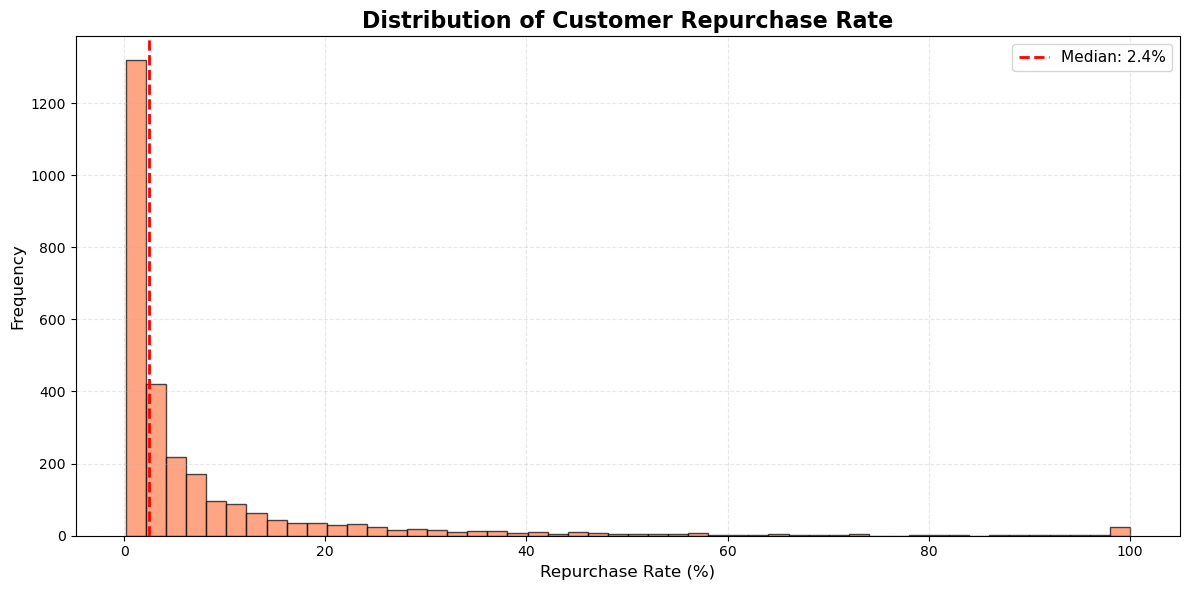

Figure 3: Distribution of Customer Repurchase Rate
Sample size: 2791
Mean: 8.14%
Median: 2.43%
Proportion of merchants with repurchase rate below 10%: 79.3%


In [29]:
# Repurchase Rate Distribution
repurchase_data = merchant_features.select("repurchase_rate").filter(
    F.col("repurchase_rate") > 0
).toPandas()

plt.figure(figsize=(12, 6))
plt.hist(repurchase_data['repurchase_rate'], bins=50, edgecolor='black', 
         alpha=0.7, color='coral')
plt.axvline(repurchase_data['repurchase_rate'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {repurchase_data["repurchase_rate"].median():.1f}%')
plt.title('Distribution of Customer Repurchase Rate', fontsize=16, fontweight='bold')
plt.xlabel('Repurchase Rate (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 3: Distribution of Customer Repurchase Rate")
print(f"Sample size: {len(repurchase_data)}")
print(f"Mean: {repurchase_data['repurchase_rate'].mean():.2f}%")
print(f"Median: {repurchase_data['repurchase_rate'].median():.2f}%")
print(f"Proportion of merchants with repurchase rate below 10%: "
      f"{(repurchase_data['repurchase_rate'] < 10).sum() / len(repurchase_data) * 100:.1f}%")


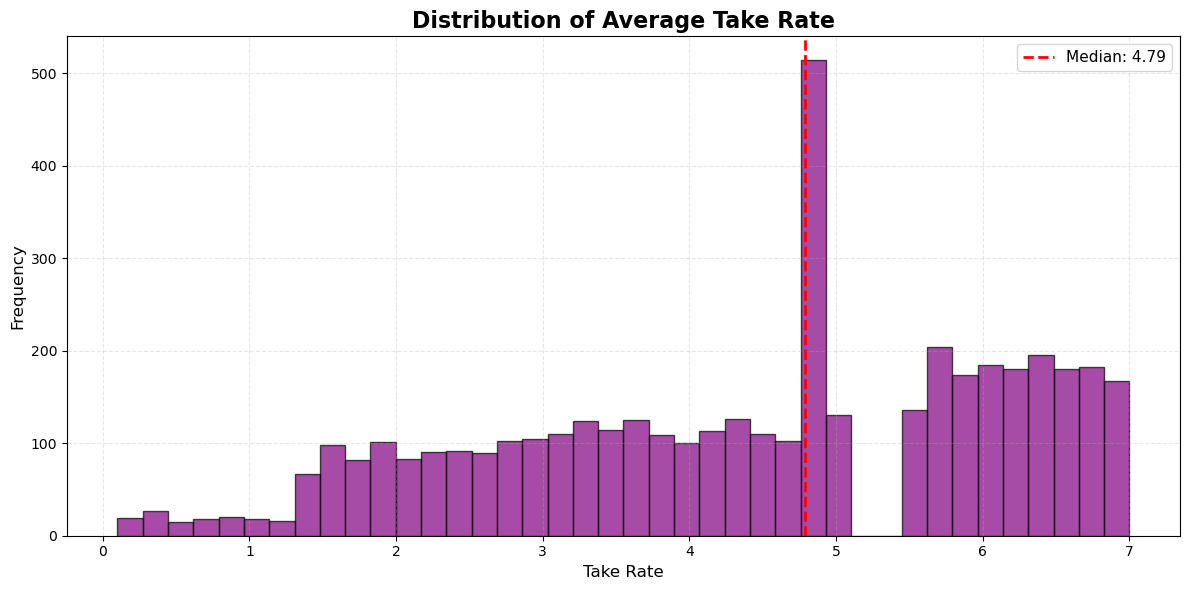

Figure 4: Take Rate Distribution Statistics
Sample size: 4422
Mean: 4.44
Median: 4.79
Range: 0.10 - 7.00


In [30]:
# Take Rate Distribution
take_rate_data = merchant_features.select("avg_take_rate").toPandas()

plt.figure(figsize=(12, 6))
plt.hist(take_rate_data['avg_take_rate'], bins=40, edgecolor='black', 
         alpha=0.7, color='purple')
plt.axvline(take_rate_data['avg_take_rate'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {take_rate_data["avg_take_rate"].median():.2f}')
plt.title('Distribution of Average Take Rate', fontsize=16, fontweight='bold')
plt.xlabel('Take Rate', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 4: Take Rate Distribution Statistics")
print(f"Sample size: {len(take_rate_data)}")
print(f"Mean: {take_rate_data['avg_take_rate'].mean():.2f}")
print(f"Median: {take_rate_data['avg_take_rate'].median():.2f}")
print(f"Range: {take_rate_data['avg_take_rate'].min():.2f} - {take_rate_data['avg_take_rate'].max():.2f}")


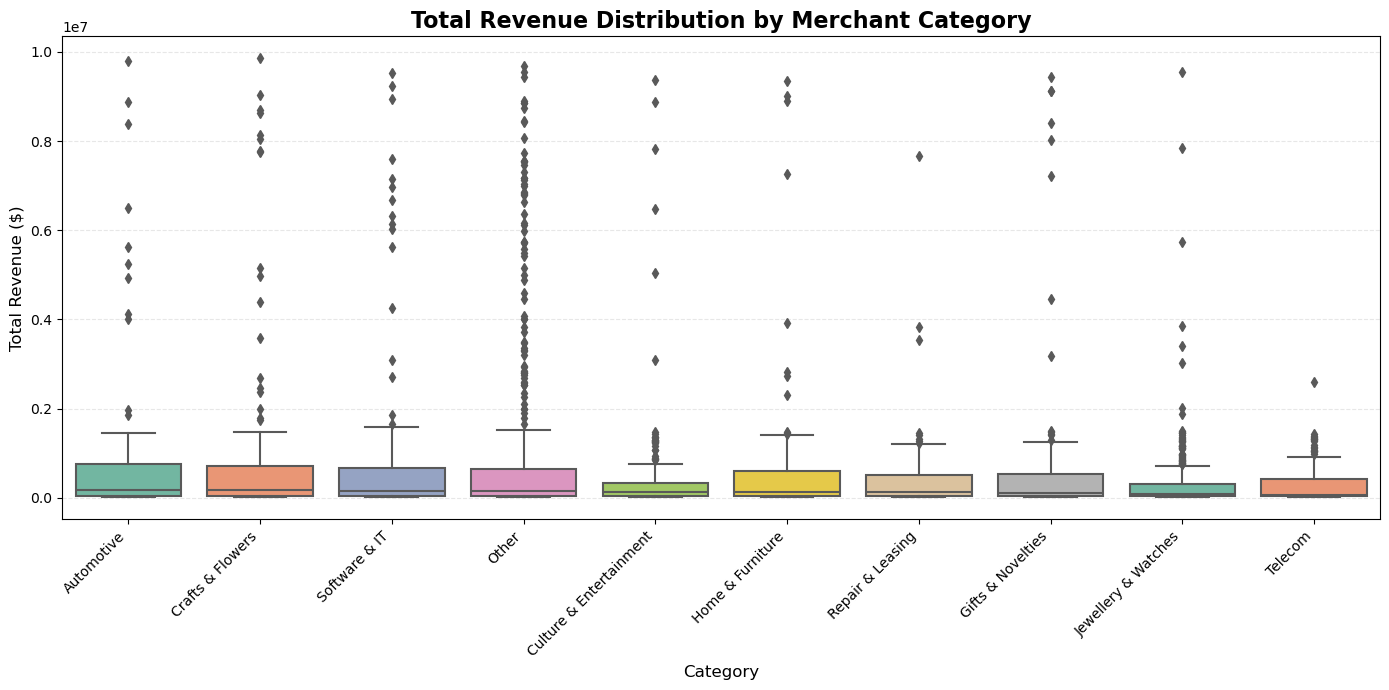

Figure 5: Boxplot Statistics of Revenue by Category
                          count           mean            50%           min  \
m_category                                                                    
Automotive                151.0  735193.858952  185471.684526  11524.997885   
Crafts & Flowers          373.0  598647.181136  167896.254542  11010.954067   
Culture & Entertainment   167.0  513611.962400  135361.424882  10612.068679   
Gifts & Novelties         182.0  611835.357400  116689.533993  11099.118537   
Home & Furniture          315.0  474873.255711  131572.855057  10696.330296   
Jewellery & Watches       258.0  403355.715961   88012.493444  10197.210889   
Other                    2340.0  493911.666488  142839.165662  10045.238145   
Repair & Leasing          128.0  428826.813884  123984.060945  11689.526576   
Software & IT             372.0  590093.882785  154339.887700  10260.206097   
Telecom                   123.0  333119.328503   72070.906784  11888.695901   


In [31]:
# Merchant category revenue distribution
category_revenue = merchant_features.select("m_category", "total_revenue").filter(
    F.col("total_revenue") < 1e7
).toPandas()

plt.figure(figsize=(14, 7))
category_order = category_revenue.groupby('m_category')['total_revenue'].median().sort_values(ascending=False).index
sns.boxplot(data=category_revenue, x='m_category', y='total_revenue', 
            order=category_order, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Total Revenue Distribution by Merchant Category', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 5: Boxplot Statistics of Revenue by Category")
category_stats = category_revenue.groupby('m_category')['total_revenue'].describe()
print(category_stats[['count', 'mean', '50%', 'min', 'max']])


In [ ]:
# Feature standardization and composite scoring
feature_cols = [
    "avg_revenue_growth_3m", "avg_transaction_amount", "repurchase_rate",
    "avg_take_rate", "total_revenue", "total_transactions", 
    "unique_customers", "avg_monthly_revenue"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
merchant_vector = assembler.transform(merchant_features.fillna(0))

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withStd=True, withMean=True)
scaler_model = scaler.fit(merchant_vector)
merchant_scaled = scaler_model.transform(merchant_vector)

def vector_to_array(v):
    return v.toArray().tolist()

vector_to_array_udf = F.udf(vector_to_array, ArrayType(DoubleType()))
merchant_scaled = merchant_scaled.withColumn("features_array", vector_to_array_udf(F.col("scaled_features")))

# Weights: revenue growth 20%, transaction amount 10%, repurchase rate 20%, 
# take rate 5%, total revenue 25%, total transactions 10%, 
# unique customers 5%, avg monthly revenue 5%
weights = [0.20, 0.10, 0.20, 0.05, 0.25, 0.10, 0.05, 0.05]

merchant_scored = merchant_scaled.withColumn(
    "composite_score",
    sum([F.col("features_array")[i] * weights[i] for i in range(len(weights))])
)

print("Model scoring completed, weight settings:")
for i, col_name in enumerate(feature_cols):
    print(f"  {col_name}: {weights[i]*100:.0f}%")


Model scoring completed, weight settings:
  avg_revenue_growth_3m: 20%
  avg_transaction_amount: 10%
  repurchase_rate: 20%
  avg_take_rate: 5%
  total_revenue: 25%
  total_transactions: 10%
  unique_customers: 5%
  avg_monthly_revenue: 5%


In [34]:
# Overall Top 100 Merchants
top_100_overall = merchant_scored.orderBy(F.desc("composite_score")).limit(100)
top_100_df = top_100_overall.select(
    "merchant_abn", "m_name", "m_category", "composite_score", 
    "total_revenue", "avg_revenue_growth_3m", "repurchase_rate", "total_transactions"
).toPandas()

print(f"\nTop 100 Merchant List:")
print(top_100_df.to_string(index=False))

print(f"\n\nTop 100 Merchant Composite Score Statistics:")
print(f"Highest Score: {top_100_df['composite_score'].max():.2f}")
print(f"Lowest Score: {top_100_df['composite_score'].min():.2f}")
print(f"Average Score: {top_100_df['composite_score'].mean():.2f}")
print(f"Median Score: {top_100_df['composite_score'].median():.2f}")



Top 100 Merchant List:
 merchant_abn                            m_name              m_category  composite_score  total_revenue  avg_revenue_growth_3m  repurchase_rate  total_transactions
  48534649627     Dignissim Maecenas Foundation                   Other        11.920254   8.444741e+07              32.890058       100.000000              596052
  93260930990           Pede Cras Vulputate Ltd                 Telecom        11.426203   1.168669e+08             114.351120       100.000000               31725
  27093785141           Placerat Orci Institute                   Other         9.824478   8.766661e+07              32.746540       100.000000              233082
  19492220327          Commodo Ipsum Industries     Jewellery & Watches         9.435373   8.038671e+07             166.673383       100.000000                8256
  90568944804                 Diam Eu Dolor LLC                   Other         8.888352   8.652407e+07              33.396720       100.000000             

In [ ]:
# Merchant Category Grouping (3 categories
merchant_scored = merchant_scored.withColumn(
    "category_group",
    F.when(F.col("m_category").isin(["Gifts & Novelties", "Crafts & Flowers", 
                                      "Jewellery & Watches", "Home & Furniture"]), "Retail Products")
    .when(F.col("m_category").isin(["Software & IT", "Telecom", "Culture & Entertainment"]), "Tech Services")
    .otherwise("Others")
)
category_groups = {
    "Retail Products": "Retailer category (Retail Products)",
    "Tech Services": "Technical service category (Tech Services)", 
    "Others": "Other comprehensive categories"
}

for cat_en, cat_cn in category_groups.items():
    print(f"\n【{cat_cn}】Top 10 merchants:")
    print("-" * 80)
    top_10 = merchant_scored.filter(F.col("category_group") == cat_en) \
        .orderBy(F.desc("composite_score")).limit(10)
    top_10_df = top_10.select(
        "merchant_abn", "m_name", "m_category", "composite_score", 
        "total_revenue", "repurchase_rate"
    ).toPandas()
    print(top_10_df.to_string(index=False))


【零售商品类 (Retail Products)】Top 10商户:
--------------------------------------------------------------------------------


 merchant_abn                            m_name          m_category  composite_score  total_revenue  repurchase_rate
  19492220327          Commodo Ipsum Industries Jewellery & Watches         9.435373   8.038671e+07       100.000000
  90918180829          Pharetra Quisque Company Jewellery & Watches         8.068430   7.125227e+07       100.000000
  79827781481                   Amet Risus Inc.    Home & Furniture         4.682921   3.893667e+07       100.000000
  86578477987                 Leo In Consulting Jewellery & Watches         4.052554   9.539823e+06        99.991695
  24852446429                    Erat Vitae LLP    Crafts & Flowers         3.985425   8.698780e+06        99.983389
  15043504837                 Odio Incorporated Jewellery & Watches         3.957664   2.830522e+07       100.000000
  45629217853                  Lacus Consulting   Gifts & Novelties         3.716088   8.395062e+06        99.904489
  43186523025    Lorem Ipsum Sodales Industries    Crafts & Flow

 merchant_abn                          m_name              m_category  composite_score  total_revenue  repurchase_rate
  93260930990         Pede Cras Vulputate Ltd                 Telecom        11.426203   1.168669e+08       100.000000
  82368304209                Nec Incorporated                 Telecom         4.685552   3.901299e+07       100.000000
  68216911708 Placerat Eget Venenatis Limited           Software & IT         3.200196   6.965564e+06        99.626013
  64403598239       Lobortis Ultrices Company Culture & Entertainment         2.983561   8.873434e+06        95.715183
  35909341340        Arcu Sed Eu Incorporated           Software & IT         1.901468   9.528214e+06        58.580315
  67400260923                     Eleifend PC           Software & IT         1.615910   5.629515e+06        58.188410
  80518954462   Neque Sed Dictum Incorporated           Software & IT         1.596349   8.939665e+06        49.155613
  84703983173                 Amet Consulting   

 merchant_abn                         m_name       m_category  composite_score  total_revenue  repurchase_rate
  48534649627  Dignissim Maecenas Foundation            Other        11.920254   8.444741e+07       100.000000
  27093785141        Placerat Orci Institute            Other         9.824478   8.766661e+07       100.000000
  90568944804              Diam Eu Dolor LLC            Other         8.888352   8.652407e+07       100.000000
  83199298021 Ligula Elit Pretium Foundation Repair & Leasing         6.077700   4.035668e+07       100.000000
  50315283629       Iaculis Aliquet Diam LLC            Other         5.230985   3.851459e+07       100.000000
  31334588839      Lacus Aliquam Corporation Repair & Leasing         4.762387   3.550761e+06       100.000000
  18158387243                 Nec Tellus Ltd            Other         4.747435   3.719771e+07       100.000000
  64203420245             Pede Nonummy Corp.            Other         3.721145   7.549445e+06        99.983389
 

In [36]:
# Amount grouping (2 categories)
median_amount = merchant_features.approxQuantile("avg_transaction_amount", [0.5], 0.01)[0]
print(f"Median transaction amount: ${median_amount:.2f}")

merchant_scored = merchant_scored.withColumn("amount_group",
    F.when(F.col("avg_transaction_amount") <= median_amount, "Small Ticket")
    .otherwise("Large Ticket"))


amount_groups = {
    "Small Ticket": "Small Ticket Merchants",
    "Large Ticket": "Large Ticket Merchants"
}

for amt_en, amt_label in amount_groups.items():
    print(f"\n[{amt_label}] Top 10 Merchants:")
    print("-" * 80)
    top_10 = merchant_scored.filter(F.col("amount_group") == amt_en) \
        .orderBy(F.desc("composite_score")).limit(10)
    top_10_df = top_10.select(
        "merchant_abn", "m_name", "avg_transaction_amount", "composite_score", 
        "total_revenue", "repurchase_rate"
    ).toPandas()
    print(top_10_df.to_string(index=False))


Median transaction amount: $333.56

[Small Ticket Merchants] Top 10 Merchants:
--------------------------------------------------------------------------------


 merchant_abn                         m_name  avg_transaction_amount  composite_score  total_revenue  repurchase_rate
  48534649627  Dignissim Maecenas Foundation              141.677921        11.920254   8.444741e+07       100.000000
  50315283629       Iaculis Aliquet Diam LLC              322.600136         5.230985   3.851459e+07       100.000000
  86578477987              Leo In Consulting               34.986184         4.052554   9.539823e+06        99.991695
  24852446429                 Erat Vitae LLP               30.046248         3.985425   8.698780e+06        99.983389
  64203420245             Pede Nonummy Corp.               28.949479         3.721145   7.549445e+06        99.983389
  45629217853               Lacus Consulting               36.779315         3.716088   8.395062e+06        99.904489
  49891706470      Non Vestibulum Industries               28.973095         3.699259   7.171594e+06        99.975081
  89726005175            Est Nunc Consulting            

 merchant_abn                         m_name  avg_transaction_amount  composite_score  total_revenue  repurchase_rate
  93260930990        Pede Cras Vulputate Ltd             3683.746893        11.426203   1.168669e+08            100.0
  27093785141        Placerat Orci Institute              376.119197         9.824478   8.766661e+07            100.0
  19492220327       Commodo Ipsum Industries             9736.762483         9.435373   8.038671e+07            100.0
  90568944804              Diam Eu Dolor LLC              896.306739         8.888352   8.652407e+07            100.0
  90918180829       Pharetra Quisque Company             9629.986353         8.068430   7.125227e+07            100.0
  83199298021 Ligula Elit Pretium Foundation            19000.320037         6.077700   4.035668e+07            100.0
  31334588839      Lacus Aliquam Corporation             4109.677155         4.762387   3.550761e+06            100.0
  18158387243                 Nec Tellus Ltd            

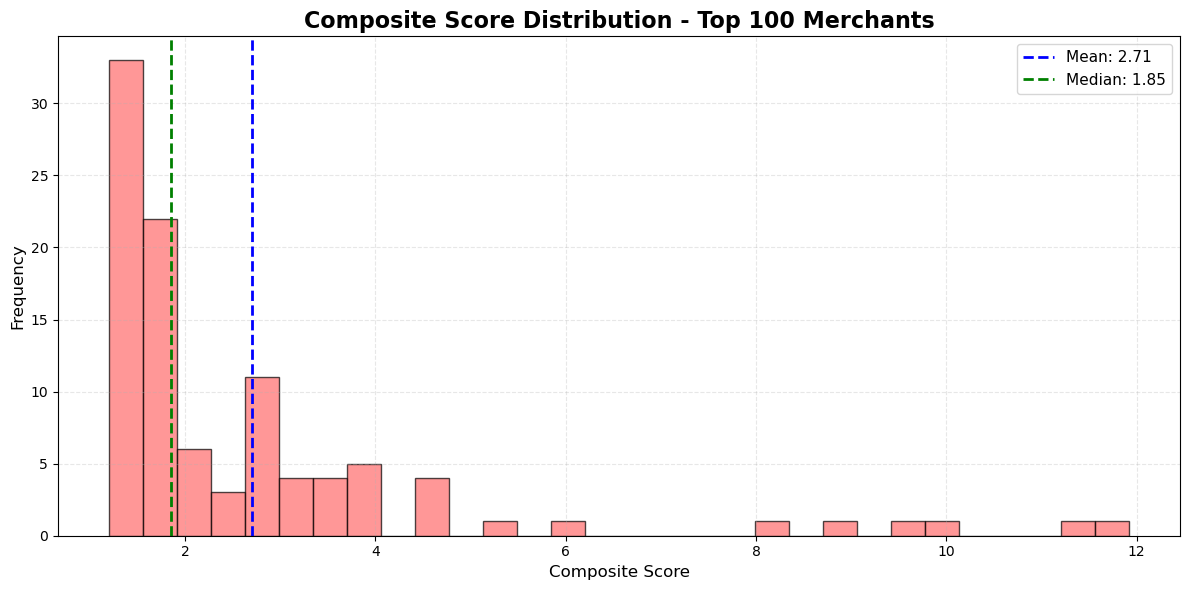

Figure 6: Composite Score Distribution - Top 100 Merchants
Sample size: 100
Score range: 1.20 - 11.92
Quartiles: Q1=1.45, Q2=1.85, Q3=3.01


In [37]:
# Composite Score Distribution - Top 100 Merchants
top_100_scores = top_100_overall.select("composite_score").toPandas()

plt.figure(figsize=(12, 6))
plt.hist(top_100_scores['composite_score'], bins=30, edgecolor='black', 
         alpha=0.7, color='#FF6B6B')
plt.axvline(top_100_scores['composite_score'].mean(), color='blue', 
            linestyle='--', linewidth=2, label=f'Mean: {top_100_scores["composite_score"].mean():.2f}')
plt.axvline(top_100_scores['composite_score'].median(), color='green', 
            linestyle='--', linewidth=2, label=f'Median: {top_100_scores["composite_score"].median():.2f}')
plt.title('Composite Score Distribution - Top 100 Merchants', fontsize=16, fontweight='bold')
plt.xlabel('Composite Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 6: Composite Score Distribution - Top 100 Merchants")
print(f"Sample size: {len(top_100_scores)}")
print(f"Score range: {top_100_scores['composite_score'].min():.2f} - {top_100_scores['composite_score'].max():.2f}")
print(f"Quartiles: Q1={top_100_scores['composite_score'].quantile(0.25):.2f}, "
      f"Q2={top_100_scores['composite_score'].median():.2f}, "
      f"Q3={top_100_scores['composite_score'].quantile(0.75):.2f}")


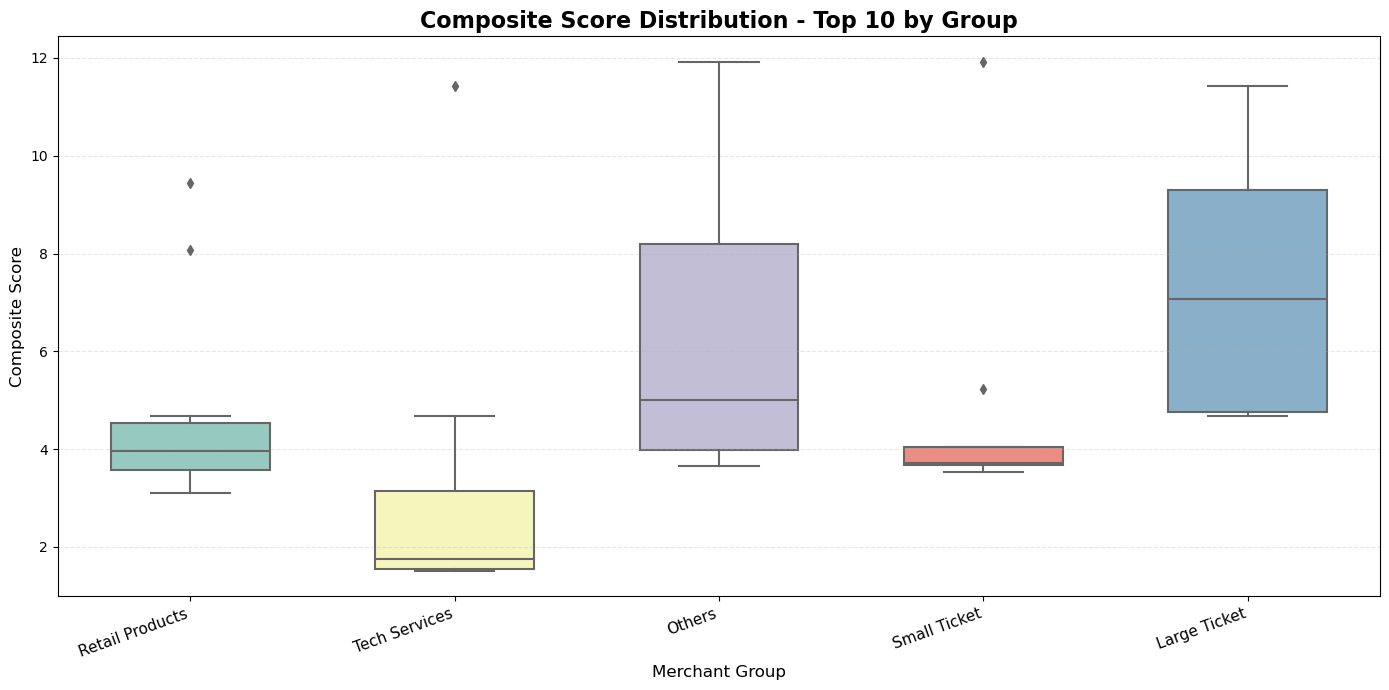

Figure 7: Composite Score Boxplot - Top 10 Merchants by Group

Key Boxplot Statistics (Five-number summary) for each group:

Retail Products:
  Minimum: 3.10
  Q1 (25%): 3.58
  Median: 3.97
  Q3 (75%): 4.53
  Maximum: 9.44
  Sample size: 10

Tech Services:
  Minimum: 1.51
  Q1 (25%): 1.55
  Median: 1.76
  Q3 (75%): 3.15
  Maximum: 11.43
  Sample size: 10

Others:
  Minimum: 3.66
  Q1 (25%): 3.98
  Median: 5.00
  Q3 (75%): 8.19
  Maximum: 11.92
  Sample size: 10

Small Ticket:
  Minimum: 3.53
  Q1 (25%): 3.67
  Median: 3.72
  Q3 (75%): 4.04
  Maximum: 11.92
  Sample size: 10

Large Ticket:
  Minimum: 4.68
  Q1 (25%): 4.75
  Median: 7.07
  Q3 (75%): 9.30
  Maximum: 11.43
  Sample size: 10


Overall Statistics by Group:
                 count      mean       std       min        max
group                                                          
Large Ticket      10.0  7.259883  2.564482  4.682921  11.426203
Others            10.0  6.252730  2.926168  3.655304  11.920254
Retail Products  

In [38]:
group_data = []
category_groups_en = ["Retail Products", "Tech Services", "Others"]

for cat in category_groups_en:
    top_10 = merchant_scored.filter(F.col("category_group") == cat) \
        .orderBy(F.desc("composite_score")).limit(10) \
        .select("composite_score", F.lit(cat).alias("group")).toPandas()
    group_data.append(top_10)

amount_groups_en = ["Small Ticket", "Large Ticket"]
for amt_group in amount_groups_en:
    top_10 = merchant_scored.filter(F.col("amount_group") == amt_group) \
        .orderBy(F.desc("composite_score")).limit(10) \
        .select("composite_score", F.lit(amt_group).alias("group")).toPandas()
    group_data.append(top_10)

all_groups = pd.concat(group_data, ignore_index=True)

plt.figure(figsize=(14, 7))
group_order = ["Retail Products", "Tech Services", "Others", "Small Ticket", "Large Ticket"]
sns.boxplot(data=all_groups, x='group', y='composite_score', order=group_order, 
            palette='Set3', width=0.6)
plt.xticks(rotation=20, ha='right', fontsize=11)
plt.title('Composite Score Distribution - Top 10 by Group', fontsize=16, fontweight='bold')
plt.xlabel('Merchant Group', fontsize=12)
plt.ylabel('Composite Score', fontsize=12)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Figure 7: Composite Score Boxplot - Top 10 Merchants by Group")
print("\nKey Boxplot Statistics (Five-number summary) for each group:")
for group in group_order:
    group_scores = all_groups[all_groups['group'] == group]['composite_score']
    if len(group_scores) > 0:
        q1, median, q3 = group_scores.quantile([0.25, 0.5, 0.75])
        print(f"\n{group}:")
        print(f"  Minimum: {group_scores.min():.2f}")
        print(f"  Q1 (25%): {q1:.2f}")
        print(f"  Median: {median:.2f}")
        print(f"  Q3 (75%): {q3:.2f}")
        print(f"  Maximum: {group_scores.max():.2f}")
        print(f"  Sample size: {len(group_scores)}")

print("\n\nOverall Statistics by Group:")
print(all_groups.groupby('group')['composite_score'].describe()[['count', 'mean', 'std', 'min', 'max']])


In [39]:
# Get full data of Top 100 merchants from merchant_scored
top_100_analysis = merchant_scored.orderBy(F.desc("composite_score")).limit(100).select(
    "merchant_abn", "m_name", "m_category", "category_group", "amount_group",
    "composite_score", "total_revenue", "avg_revenue_growth_3m", 
    "repurchase_rate", "avg_transaction_amount", "total_transactions",
    "unique_customers", "avg_take_rate"
).toPandas()

print("Top 100 Merchants Data Sample:")
print(top_100_analysis.head(10).to_string(index=False))


Top 100 Merchants Data Sample:
 merchant_abn                         m_name          m_category  category_group amount_group  composite_score  total_revenue  avg_revenue_growth_3m  repurchase_rate  avg_transaction_amount  total_transactions  unique_customers  avg_take_rate
  48534649627  Dignissim Maecenas Foundation               Other          Others Small Ticket        11.920254   8.444741e+07              32.890058            100.0              141.677921              596052             22573           6.64
  93260930990        Pede Cras Vulputate Ltd             Telecom   Tech Services Large Ticket        11.426203   1.168669e+08             114.351120            100.0             3683.746893               31725              1246           3.15
  27093785141        Placerat Orci Institute               Other          Others Large Ticket         9.824478   8.766661e+07              32.746540            100.0              376.119197              233082             15831           2.

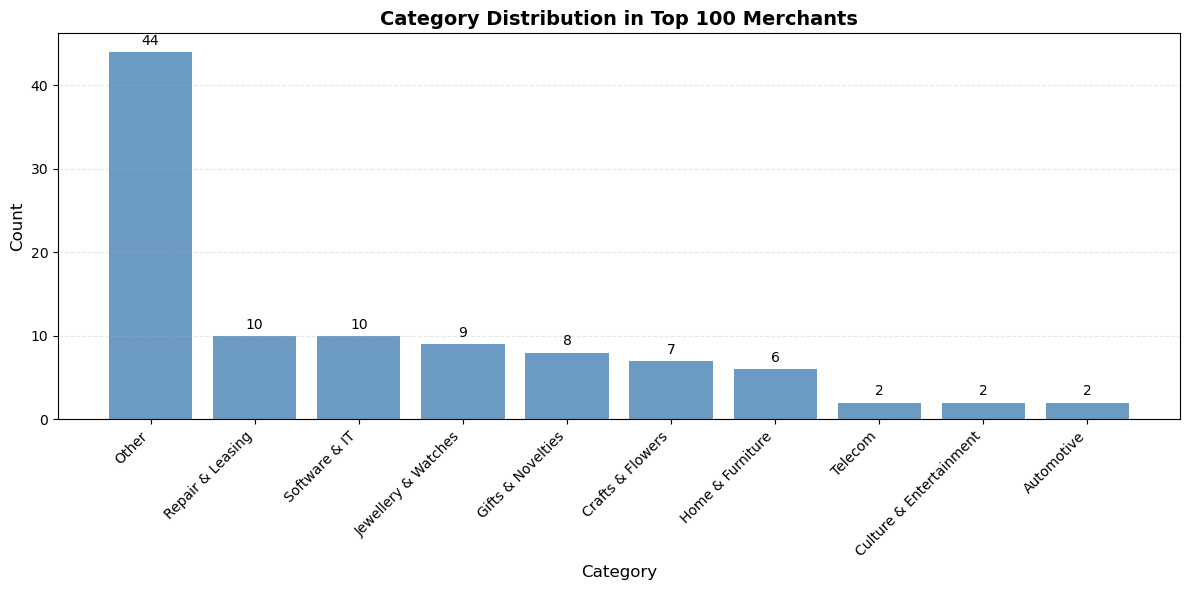

Category Distribution in Top 100 Merchants:
m_category
Other                      44
Repair & Leasing           10
Software & IT              10
Jewellery & Watches         9
Gifts & Novelties           8
Crafts & Flowers            7
Home & Furniture            6
Telecom                     2
Culture & Entertainment     2
Automotive                  2

Total number of categories: 10
Most frequent category: Other (44 merchants)


In [40]:
# Analysis 1: Category Distribution
category_dist = top_100_analysis['m_category'].value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(category_dist)), category_dist.values, color='steelblue', alpha=0.8)
plt.xticks(range(len(category_dist)), category_dist.index, rotation=45, ha='right')
plt.title('Category Distribution in Top 100 Merchants', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (cat, val) in enumerate(category_dist.items()):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Category Distribution in Top 100 Merchants:")
print(category_dist.to_string())
print(f"\nTotal number of categories: {len(category_dist)}")
print(f"Most frequent category: {category_dist.index[0]} ({category_dist.values[0]} merchants)")


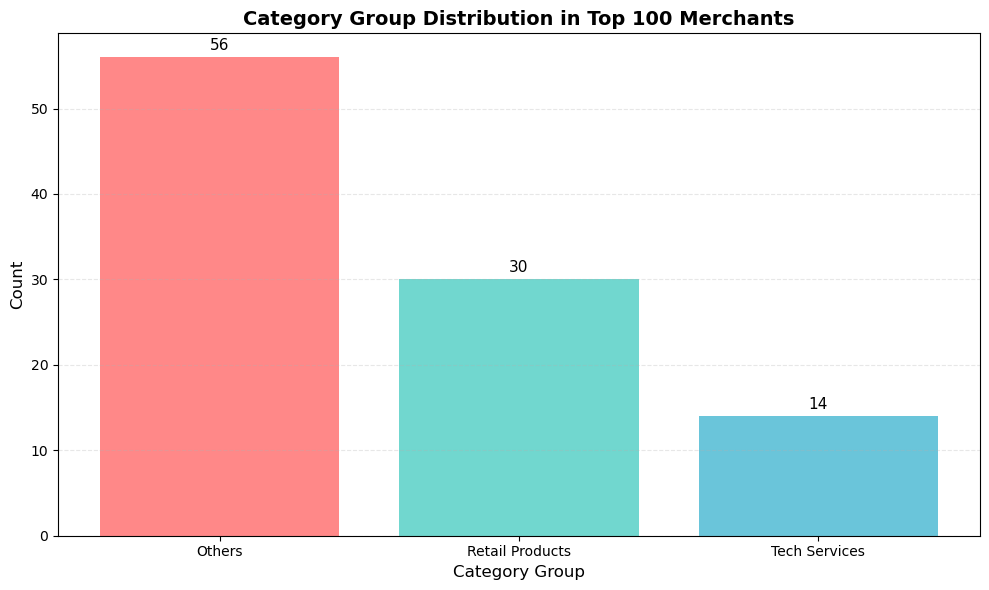

Category Group Distribution in Top 100 Merchants:
category_group
Others             56
Retail Products    30
Tech Services      14


In [41]:
# Analysis 2: Category Group Distribution
category_group_dist = top_100_analysis['category_group'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(category_group_dist.index, category_group_dist.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
plt.title('Category Group Distribution in Top 100 Merchants', fontsize=14, fontweight='bold')
plt.xlabel('Category Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (group, val) in enumerate(category_group_dist.items()):
    plt.text(i, val + 0.5, f'{val}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("Category Group Distribution in Top 100 Merchants:")
print(category_group_dist.to_string())


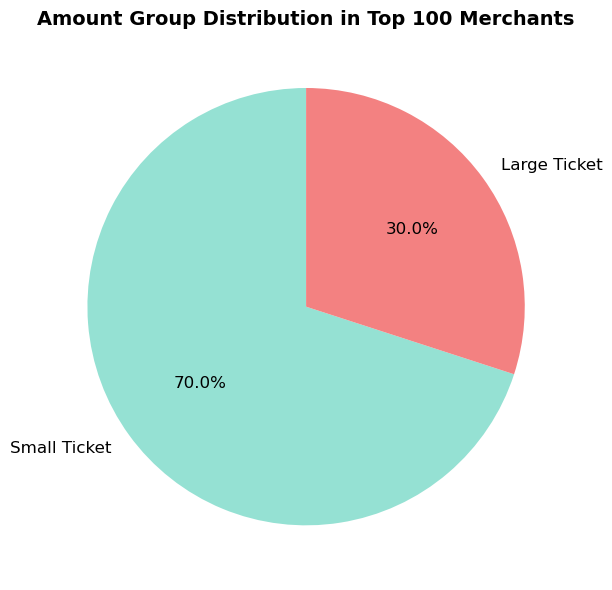

Amount Group Distribution in Top 100 Merchants:
amount_group
Small Ticket    70
Large Ticket    30


In [42]:
# Analysis 3: Amount Group Distribution
amount_group_dist = top_100_analysis['amount_group'].value_counts()

plt.figure(figsize=(10, 6))
colors = ['#95E1D3', '#F38181']
plt.pie(amount_group_dist.values, labels=amount_group_dist.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Amount Group Distribution in Top 100 Merchants', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Amount Group Distribution in Top 100 Merchants:")
print(amount_group_dist.to_string())


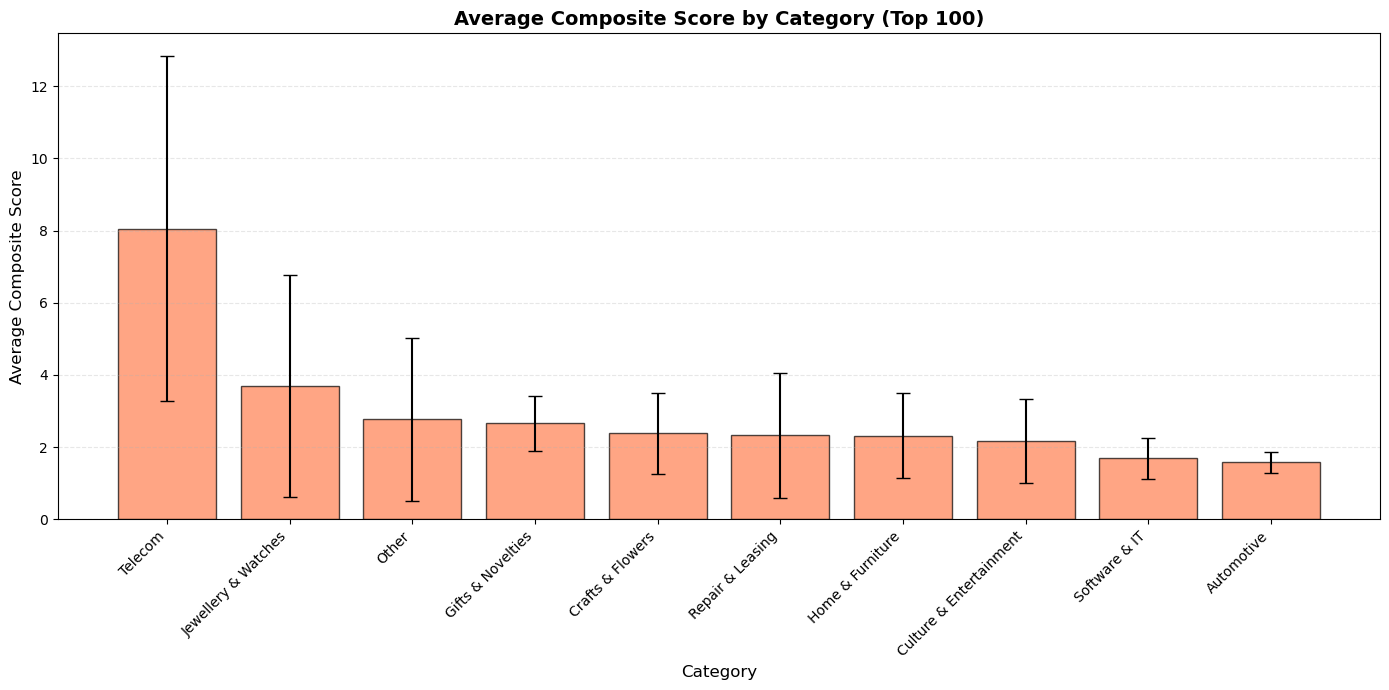

Average Composite Score Statistics by Category:
                         count      mean       std       min        max
m_category                                                             
Telecom                      2  8.055878  4.766360  4.685552  11.426203
Jewellery & Watches          9  3.693934  3.081230  1.200665   9.435373
Other                       44  2.766416  2.266863  1.250415  11.920254
Gifts & Novelties            8  2.657091  0.766705  1.295424   3.716088
Crafts & Flowers             7  2.381973  1.117626  1.360806   3.985425
Repair & Leasing            10  2.325726  1.723875  1.282840   6.077700
Home & Furniture             6  2.319901  1.173315  1.611350   4.682921
Culture & Entertainment      2  2.165007  1.157611  1.346452   2.983561
Software & IT               10  1.685682  0.560698  1.253227   3.200196
Automotive                   2  1.578035  0.282306  1.378415   1.777656


In [43]:
# Analysis 4: Relationship between Score and Category
category_score_stats = top_100_analysis.groupby('m_category')['composite_score'].agg(['count', 'mean', 'std', 'min', 'max'])
category_score_stats = category_score_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 7))
x_pos = range(len(category_score_stats))
plt.bar(x_pos, category_score_stats['mean'], yerr=category_score_stats['std'], 
        capsize=5, alpha=0.7, color='coral', edgecolor='black')
plt.xticks(x_pos, category_score_stats.index, rotation=45, ha='right')
plt.title('Average Composite Score by Category (Top 100)', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Composite Score', fontsize=12)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Average Composite Score Statistics by Category:")
print(category_score_stats.to_string())


In [44]:
# Analysis 5: 100% Repurchase Rate Merchant Analysis
perfect_repurchase = top_100_analysis[top_100_analysis['repurchase_rate'] == 100.0]
non_perfect_repurchase = top_100_analysis[top_100_analysis['repurchase_rate'] < 100.0]

print(f"Number of merchants with 100% repurchase rate: {len(perfect_repurchase)}")
print(f"Number of merchants with less than 100% repurchase rate: {len(non_perfect_repurchase)}")

if len(perfect_repurchase) > 0:
    perfect_score_stats = perfect_repurchase['composite_score'].describe()
    print("\nScore statistics for merchants with 100% repurchase rate:")
    print(perfect_score_stats.to_string())
    
if len(non_perfect_repurchase) > 0:
    non_perfect_score_stats = non_perfect_repurchase['composite_score'].describe()
    print("\nScore statistics for merchants with less than 100% repurchase rate:")
    print(non_perfect_score_stats.to_string())


Number of merchants with 100% repurchase rate: 14
Number of merchants with less than 100% repurchase rate: 86

Score statistics for merchants with 100% repurchase rate:
count    14.000000
mean      6.889141
std       2.966897
min       2.740234
25%       4.701023
50%       5.654342
75%       9.298618
max      11.920254

Score statistics for merchants with less than 100% repurchase rate:
count    86.000000
mean      2.024205
std       0.786298
min       1.200665
25%       1.376379
50%       1.744463
75%       2.633817
max       4.052554


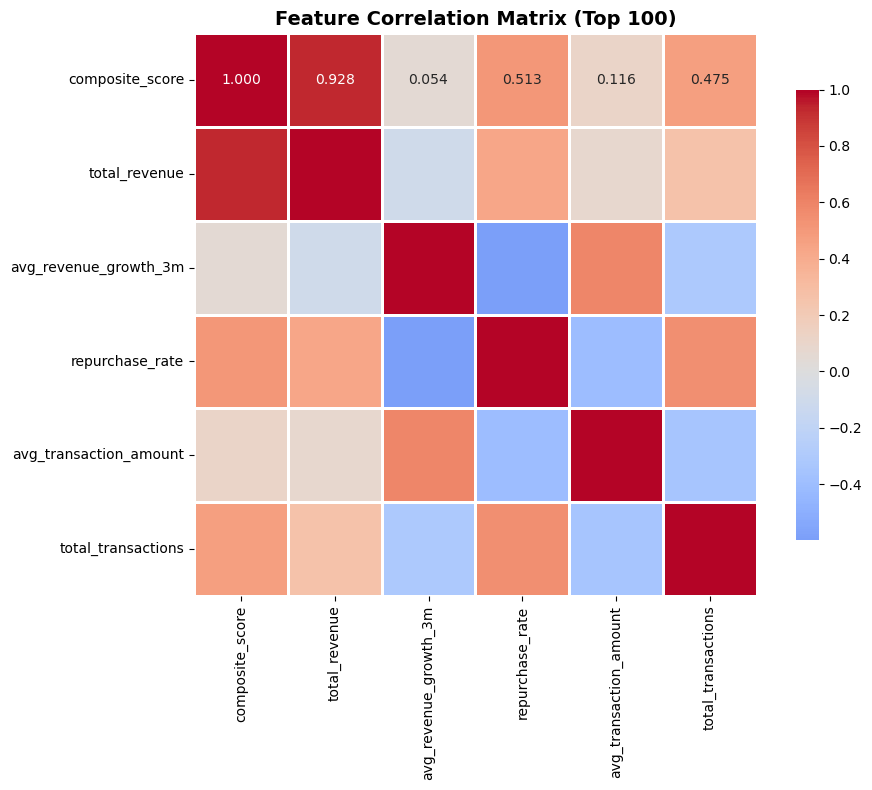

特征相关系数矩阵:
                        composite_score  total_revenue  avg_revenue_growth_3m  repurchase_rate  avg_transaction_amount  total_transactions
composite_score                1.000000       0.928225               0.053752         0.512846                0.115921            0.474939
total_revenue                  0.928225       1.000000              -0.093314         0.426678                0.078131            0.263681
avg_revenue_growth_3m          0.053752      -0.093314               1.000000        -0.596823                0.591089           -0.315250
repurchase_rate                0.512846       0.426678              -0.596823         1.000000               -0.403534            0.545182
avg_transaction_amount         0.115921       0.078131               0.591089        -0.403534                1.000000           -0.345476
total_transactions             0.474939       0.263681              -0.315250         0.545182               -0.345476            1.000000


In [ ]:
# Analysis 6: Correlation between Scores and Key Features
correlation_features = ['composite_score', 'total_revenue', 'avg_revenue_growth_3m', 
                       'repurchase_rate', 'avg_transaction_amount', 'total_transactions']
correlation_matrix = top_100_analysis[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Top 100)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Feature correlation coefficient matrix:")
print(correlation_matrix.to_string())

In [46]:
# Analysis 7: Feature Analysis of High-Scoring Merchants (Score > 5)
high_score_threshold = 5.0
high_score_merchants = top_100_analysis[top_100_analysis['composite_score'] > high_score_threshold]
low_score_merchants = top_100_analysis[top_100_analysis['composite_score'] <= high_score_threshold]

print(f"Number of high-scoring merchants (>{high_score_threshold}): {len(high_score_merchants)}")
print(f"Number of low-scoring merchants (<={high_score_threshold}): {len(low_score_merchants)}")

feature_comparison = pd.DataFrame({
    'High_Score_Mean': high_score_merchants[['total_revenue', 'avg_revenue_growth_3m', 
                                             'repurchase_rate', 'total_transactions']].mean(),
    'Low_Score_Mean': low_score_merchants[['total_revenue', 'avg_revenue_growth_3m', 
                                           'repurchase_rate', 'total_transactions']].mean()
})

print("\nFeature comparison: High-scoring vs Low-scoring merchants:")
print(feature_comparison.to_string())


Number of high-scoring merchants (>5.0): 8
Number of low-scoring merchants (<=5.0): 92

Feature comparison: High-scoring vs Low-scoring merchants:
                       High_Score_Mean  Low_Score_Mean
total_revenue             7.575190e+07    6.478926e+06
avg_revenue_growth_3m     8.989297e+01    8.087380e+01
repurchase_rate           1.000000e+02    6.241666e+01
total_transactions        1.368200e+05    6.204121e+04


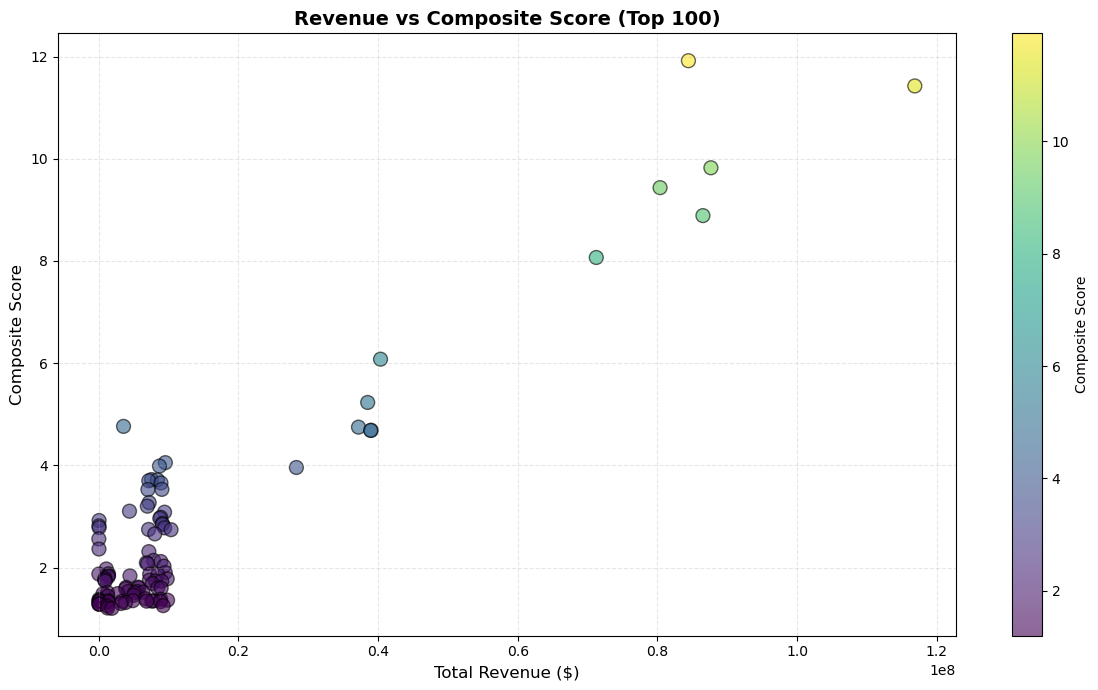

Correlation between revenue and composite score: 0.9282

Revenue quartiles:
Q1: $1,385,239.15
Q2 (Median): $7,022,557.76
Q3: $8,958,774.73


In [47]:
# Analysis 8: Relationship between Revenue and Score
plt.figure(figsize=(12, 7))
scatter = plt.scatter(top_100_analysis['total_revenue'], 
                     top_100_analysis['composite_score'],
                     c=top_100_analysis['composite_score'], 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black')
plt.colorbar(scatter, label='Composite Score')
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Composite Score', fontsize=12)
plt.title('Revenue vs Composite Score (Top 100)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

revenue_score_corr = top_100_analysis[['total_revenue', 'composite_score']].corr().iloc[0, 1]
print(f"Correlation between revenue and composite score: {revenue_score_corr:.4f}")

revenue_quartiles = top_100_analysis['total_revenue'].quantile([0.25, 0.5, 0.75])
print("\nRevenue quartiles:")
print(f"Q1: ${revenue_quartiles[0.25]:,.2f}")
print(f"Q2 (Median): ${revenue_quartiles[0.5]:,.2f}")
print(f"Q3: ${revenue_quartiles[0.75]:,.2f}")


<Figure size 1000x600 with 0 Axes>

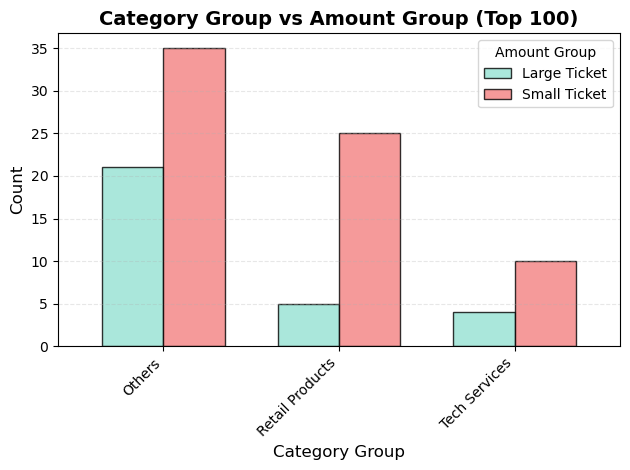

Cross-tabulation of Category Group and Amount Group:
amount_group     Large Ticket  Small Ticket
category_group                             
Others                     21            35
Retail Products             5            25
Tech Services               4            10


In [48]:
# Analysis 9: Cross Analysis of Category Group and Amount Group
cross_tab = pd.crosstab(top_100_analysis['category_group'], 
                        top_100_analysis['amount_group'])

plt.figure(figsize=(10, 6))
cross_tab.plot(kind='bar', stacked=False, color=['#95E1D3', '#F38181'], 
               alpha=0.8, edgecolor='black', width=0.7)
plt.title('Category Group vs Amount Group (Top 100)', fontsize=14, fontweight='bold')
plt.xlabel('Category Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Amount Group', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Cross-tabulation of Category Group and Amount Group:")
print(cross_tab.to_string())


In [49]:
# Analysis 10: Detailed Features of Top 10 High-Scoring Merchants
top_10_detailed = top_100_analysis.nlargest(10, 'composite_score')[
    ['merchant_abn', 'm_category', 'category_group', 'amount_group', 
     'composite_score', 'total_revenue', 'repurchase_rate', 'total_transactions']
]

print("Detailed information of Top 10 high-scoring merchants:")
print(top_10_detailed.to_string(index=False))

top_10_category_dist = top_10_detailed['m_category'].value_counts()
print("\nCategory distribution of Top 10 merchants:")
print(top_10_category_dist.to_string())


Detailed information of Top 10 high-scoring merchants:
 merchant_abn          m_category  category_group amount_group  composite_score  total_revenue  repurchase_rate  total_transactions
  48534649627               Other          Others Small Ticket        11.920254   8.444741e+07            100.0              596052
  93260930990             Telecom   Tech Services Large Ticket        11.426203   1.168669e+08            100.0               31725
  27093785141               Other          Others Large Ticket         9.824478   8.766661e+07            100.0              233082
  19492220327 Jewellery & Watches Retail Products Large Ticket         9.435373   8.038671e+07            100.0                8256
  90568944804               Other          Others Large Ticket         8.888352   8.652407e+07            100.0               96534
  90918180829 Jewellery & Watches Retail Products Large Ticket         8.068430   7.125227e+07            100.0                7399
  83199298021    Repa